In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json, pickle
import os

from qiskit_ibm_provider import IBMProvider
from qiskit import QuantumCircuit, transpile
import stim
from datetime import datetime

from src.heavyHEX3CX_v2 import heavyHEX3CX as heavyHEX3CX_b
from src.utils import transDD, get_stim_circuits, plot_3d_threshold, fit_plane, Threshold_from_LogFail, LogFail_of_d_p, Log_fail_error_model,get_noise_dict_from_backend #, add_dynamic_decoupling
import src.surface_code_decoder

import time

home = os.getcwd()

In [2]:
d=10
T=10

logical_observable='Z'
HH3CX = heavyHEX3CX_b(d=d,T=T, logical_observable=logical_observable, CXerror=0.1, offset = 0,link_reset=False,num_qubits=-1, skipCX=False)

HH3CX.stim_circuit

HH3CX.stim_circuit.detector_error_model(decompose_errors=True, approximate_disjoint_errors = True).num_errors/HH3CX.stim_circuit.detector_error_model(decompose_errors=True, approximate_disjoint_errors = True).num_detectors

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10e0c6cc0>>
Traceback (most recent call last):
  File "/Users/het/miniconda3/envs/qiskit-qec-2/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [3]:
# provider = IBMQ.providers()[1]
# for i,be in enumerate(provider.backends()):
#     print(i, be.name(),be.status().pending_jobs)

In [4]:
provider = IBMProvider(instance= '',token ='')
backend = provider.get_backend('ibm_sherbrooke')
backend

<IBMBackend('ibm_sherbrooke')>

## Detector Likelihood

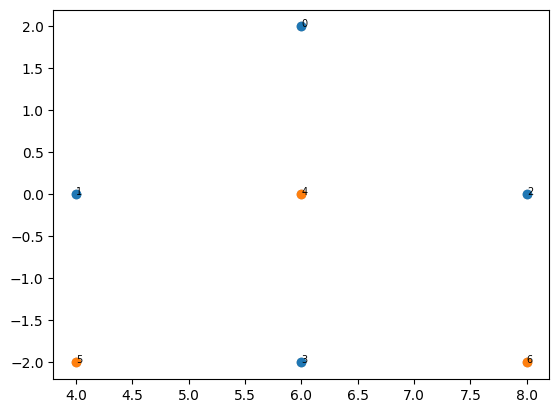

In [17]:
d=2
T=1

logical_observable='Z'
HH3CX = heavyHEX3CX(d=d,T=T, logical_observable=logical_observable, offset = 0,link_reset=False,num_qubits=-1, skipCX=False)

qc = HH3CX.circuit

HH3CX.draw_lattice()

In [21]:
HH3CX = heavyHEX3CX(d=d,T=T, logical_observable=logical_observable, offset = 0,link_reset=False,num_qubits=-1, skipCX=False)
HH3CX_noisy = heavyHEX3CX(d=d,T=T, logical_observable=logical_observable, offset = 0,link_reset=False,
                          CXerror = 0.01,Rerror=0.012, singleQerror = 0.0001,
                          num_qubits=-1)

In [22]:
qc_noisy = HH3CX_noisy.circuit

stim_circuit = HH3CX_noisy.stim_circuit

# d = HH3CX_noisy.d
# T = HH3CX_noisy.T
# for detector in HH3CX_noisy.error_sensitive_events:
#     stim_circuit.append("DETECTOR",[stim.target_rec(measind-((d**2-1)*T+d**2)) for measind in detector])
# stim_circuit.append("OBSERVABLE_INCLUDE", [stim.target_rec(HH3CX_noisy.measuredict[(pos,T)]-((d**2-1)*T+d**2)) for pos in HH3CX_noisy.edge_qubit_pos],0)

stim_DEM = stim_circuit.detector_error_model(decompose_errors=True,approximate_disjoint_errors=True)
matching = surface_code_decoder.detector_error_model_to_pymatching_graph(stim_DEM)
print(len(stim_circuit.shortest_graphlike_error()))

2


In [28]:
ese = HH3CX_noisy.error_sensitive_events

ind_to_coord = {v:k for k,v in HH3CX_noisy.measuredict.items()}
for det in ese:
    det_coord = []
    for meas_ind in det:
        det_coord.append(ind_to_coord[meas_ind])
    if all([m_coord[0].real%2 for m_coord in det_coord]):
        print('BS ',det_coord)
    elif not any([m_coord[0].real%2 for m_coord in det_coord]):
        print('3CX ',det_coord)
    else:
        print('3CX + BS ',det_coord)

3CX  [((4+4j), 0)]
3CX  [((8+4j), 0)]
3CX  [((4+4j), 0), ((8+4j), 0), ((6+6j), 1), ((6+2j), 1), ((2+6j), 1), ((2+2j), 1)]


In [23]:
HH3CX.circuit.draw(fold=-1,idle_wires=False)

░ ┌───┐ ░       ░       ░            ░  ░ ┌─────────────────┐      ┌─┐         
q_0: ──────░─┤ X ├─░───────░───────░────────■───░──░─┤ Quantum_channel ├──────┤M├─────────
           ░ └─┬─┘ ░       ░       ░ ┌───┐  │   ░  ░ ├─────────────────┤      └╥┘┌─┐      
q_1: ──────░───┼───░───────░───■───░─┤ X ├──┼───░──░─┤ Quantum_channel ├───────╫─┤M├──────
     ┌───┐ ░   │   ░       ░ ┌─┴─┐ ░ └─┬─┘┌─┴─┐ ░  ░ └─────────────────┘┌─┐    ║ └╥┘      
q_2: ┤ H ├─░───■───░───■───░─┤ X ├─░───┼──┤ X ├─░──░────────────────────┤M├────╫──╫───────
     ├───┤ ░       ░   │   ░ └───┘ ░   │  └───┘ ░  ░        ┌───┐       └╥┘┌─┐ ║  ║       
q_3: ┤ H ├─░───────░───┼───░───■───░───■────────░──░────────┤ H ├────────╫─┤M├─╫──╫───────
     └───┘ ░       ░ ┌─┴─┐ ░   │   ░            ░  ░ ┌──────┴───┴──────┐ ║ └╥┘ ║  ║ ┌─┐   
q_4: ──────░───■───░─┤ X ├─░───┼───░────────────░──░─┤ Quantum_channel ├─╫──╫──╫──╫─┤M├───
           ░   │   ░ └───┘ ░ ┌─┴─┐ ░            ░  ░ ├─────────────────┤ ║  ║  ║  ║ └╥┘┌─┐
q_5: ──────░───┼───░───■───░─┤ X ├─░────────────░──░─┤ Quantum_channel ├─╫──╫──╫──╫──╫─┤M├
           ░ ┌─┴─┐ ░ ┌─┴─┐ ░ └───┘ ░            ░  ░ └───────┬─┬───────┘ ║  ║  ║  ║  ║ └╥┘
q_6: ──────░─┤ X ├─░─┤ X ├─░───────░────────────░──░─────────┤M├─────────╫──╫──╫──╫──╫──╫─
           ░ └───┘ ░ └───┘ ░       ░            ░  ░         └╥┘         ║  ║  ║  ║  ║  ║ 
c: 7/═════════════════════════════════════════════════════════╩══════════╩══╩══╩══╩══╩══╩═
                                                              2          1  0  3  4  5  6

In [15]:
stim_DEM

stim.DetectorErrorModel('''
    error(0.01444) D0
    error(0.0414859) D0 D2
    error(0.0359051) D0 L0
    error(0.01444) D1
    error(0.0479699) D1 D2
    error(0.01444) D1 L0
    error(0.0692428) D2
    error(0.0493082) D2 L0
    error(0.0049875) D2 L0 ^ D0 L0
    error(0.0025) D2 L0 ^ D1 L0
    error(0.0025) D2 ^ D0
    error(0.0025) D2 ^ D1
''')

In [16]:
# stim_circuit

In [17]:
num_correct = 0
num_fail = 0
num_physfail = 0

num_shots = 100_000
detector_samples = stim_circuit.compile_detector_sampler().sample(num_shots, append_observables=True) 

for sample in detector_samples:
    actual_observable = sample[-1]
    detectors_only = sample.copy()
    detectors_only[-1] = 0
    predicted_observable = matching.decode(detectors_only)[0]
    num_physfail += actual_observable
    num_fail += actual_observable != predicted_observable
    num_correct += actual_observable == predicted_observable

print(HH3CX.detector_likelihood(detector_samples),HH3CX.detector_likelihood(detector_samples,spatial_boundaries=True),HH3CX.detector_likelihood(detector_samples,spatial_boundaries=True,temporal_boundaries=True))
num_correct/num_shots, (num_shots-num_physfail)/num_shots

0.27469 0.22515571428574072 0.18918521739132294


(0.88708, 0.72972)

In [18]:
num_shots = 2**14
d_list = list(range(2,11))
DL_bulk = []
DL_SP = []
DL_SPTE = []
for d in d_list:
    T=3
    # start_time = time.time()
    HH3CX = heavyHEX3CX(d=d,T=T, logical_observable=logical_observable, offset = 0,link_reset=False,num_qubits=-1, skipCX=False)
    HH3CX_noisy = heavyHEX3CX(d=d,T=T, logical_observable=logical_observable, offset = 0,link_reset=False,CXerror = 0.004,num_qubits=-1, skipCX=False)
    # qc_noisy = HH3CX_noisy.circuit
    stim_circuit = HH3CX_noisy.stim_circuit #get_stim_circuits(qc_noisy)[0][0][:-2]

    # for detector in HH3CX_noisy.error_sensitive_events:
    #     stim_circuit.append("DETECTOR",[stim.target_rec(measind-((d**2-1)*T+d**2)) for measind in detector])
    # stim_circuit.append("OBSERVABLE_INCLUDE", [stim.target_rec(HH3CX_noisy.measuredict[(pos,T)]-((d**2-1)*T+d**2)) for pos in HH3CX_noisy.edge_qubit_pos],0)

    stim_DEM = stim_circuit.detector_error_model(decompose_errors=True,approximate_disjoint_errors=True,ignore_decomposition_failures=True)
    matching = surface_code_decoder.detector_error_model_to_pymatching_graph(stim_DEM)

    num_correct = 0
    num_fail = 0
    num_physfail = 0

    detector_samples = stim_circuit.compile_detector_sampler().sample(num_shots, append_observables=True) 

    for sample in detector_samples:
        actual_observable = sample[-1]
        detectors_only = sample.copy()
        detectors_only[-1] = 0
        predicted_observable = matching.decode(detectors_only)[0]
        num_physfail += actual_observable
        num_fail += actual_observable != predicted_observable
        num_correct += actual_observable == predicted_observable
    DL_bulk.append(HH3CX_noisy.detector_likelihood(detector_samples))
    DL_SP.append(HH3CX_noisy.detector_likelihood(detector_samples,spatial_boundaries=True))
    DL_SPTE.append(HH3CX_noisy.detector_likelihood(detector_samples,spatial_boundaries=True,temporal_boundaries=True))
    print(d, HH3CX_noisy.detector_likelihood_from_DEM(),HH3CX_noisy.detector_likelihood_from_DEM(spatial_boundaries=True),HH3CX_noisy.detector_likelihood_from_DEM(spatial_boundaries=True,temporal_boundaries=True))
    print(d, HH3CX_noisy.detector_likelihood(detector_samples),HH3CX_noisy.detector_likelihood(detector_samples,spatial_boundaries=True),HH3CX_noisy.detector_likelihood(detector_samples,spatial_boundaries=True,temporal_boundaries=True))
    # print(d,(num_shots-num_correct)/num_shots, num_physfail/num_shots,HH3CX.detector_likelihood(detector_samples))

2 0 0.01698107859031846 0.013104658411172093
2 0.0 0.017842610677083343 0.013448079427083271
3 0 0.0242569533739423 0.02127211796004623
3 0.0 0.02423858642578125 0.021175384521484375
4 0.025038889617246037 0.02809202146598774 0.023393302993811833
4 0.02447509765625 0.027600097656249035 0.02287394205729245
5 0.04029717740323383 0.03054067335875577 0.026794289150904944
5 0.04025268554687465 0.03045654296875054 0.02670288085937498
6 0.031773927269772684 0.0322527165293653 0.027763718291509462
6 0.03141276041666564 0.032221330915179154 0.027764892578125942
7 0.041032728734016026 0.03352052375143468 0.029413294464022202
7 0.04125061035156243 0.033819834391275776 0.029527664184570264
8 0.035614298080383945 0.03449838541122649 0.029975395781109075
8 0.035113525390628106 0.0341399662078335 0.02974495055183131
9 0.04134796501863695 0.03527603206711382 0.030956281595447516
9 0.041592552548357864 0.03531799316406193 0.031117248535156367
10 0.03736891434691569 0.03590949423361886 0.031323827544730

In [11]:
stim_DEM = HH3CX_noisy.stim_circuit.detector_error_model(decompose_errors=True,approximate_disjoint_errors=True)

temporal_boundaries = False
spatial_boundaries = True
meas_inv = {v:k for k,v ,in HH3CX_noisy.measuredict.items()}
bulk_det_inds = []
for i, ese in enumerate(HH3CX_noisy.error_sensitive_events):
    ese_time = 0
    is_at_boundary = False
    for meas_ind in ese:
        pos,time = meas_inv[meas_ind]
        if time>ese_time:
            ese_time = time
        if pos.real in [4,4*d] or pos.imag in [4,4*d]:
            is_at_boundary = True
    if temporal_boundaries or (ese_time!=0 and ese_time!=T):
        if spatial_boundaries or not is_at_boundary:
            bulk_det_inds.append(i)

det_probs={}
for instruction in stim_DEM:
    if isinstance(instruction, stim.DemInstruction):
        if instruction.type == "error":
            dets = []
            frames = []
            t: stim.DemTarget
            p = instruction.args_copy()[0]
            for t in instruction.targets_copy():
                if t.is_relative_detector_id():
                    t = t.val
                    if t in bulk_det_inds:
                        if t in det_probs:
                            old_p = det_probs[t]
                            new_p = old_p*(1-p)+p*(1-old_p)
                            det_probs[t] = new_p
                        else:
                            det_probs[t] = p

freqs = []
probs = []
for prob in det_probs.values():
    prob = round(prob,10)
    if prob in probs:
        freqs[probs.index(prob)]+=1
    else:
        probs.append(prob)
        freqs.append(1)

list(zip(freqs,probs))

np.dot(freqs,probs)/sum(freqs)

0.035909484397474746

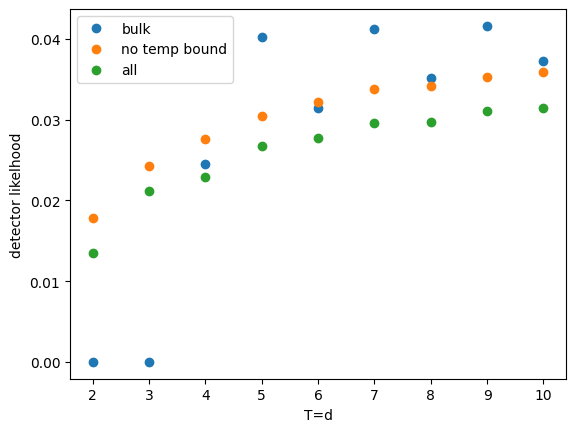

In [19]:
plt.plot(d_list,DL_bulk,'o')
plt.plot(d_list,DL_SP,'o')
plt.plot(d_list,DL_SPTE,'o')
plt.legend(['bulk','no temp bound','all'])
plt.xlabel('T=d')
plt.ylabel('detector likelhood')
plt.show()

In [9]:
import numpy as np
from typing import *
import matplotlib.pyplot as plt

def LogFail_of_d_p(code_circuit_class,
                   theta: float, phi: float,  logical: str,
                   dist_list: List[int], error_list: List[float],
                   max_shots: int, shot_batch: int, max_num_fail: int,
                   T_over_d: float = 1, max_fail_rate: float = 0.49, DL=False, **kwargs):
    Log_fail_d_p = []
    for d in dist_list:
        Log_fail_p =[]
        for error in error_list:
            if len(Log_fail_p) == 0 or Log_fail_p[-1][1] < max_fail_rate:
                code = code_circuit_class(d=d, T=int(T_over_d*d), logical_observable=logical,
                                            singleQerror = 0.01*error*np.cos(theta)*np.cos(phi), CXerror = error*np.cos(theta)*np.cos(phi),
                                            idleerror = error*np.cos(theta)*np.sin(phi), 
                                            Rerror = error*np.sin(theta),**kwargs)
                stim_circuit = code.stim_circuit
                
                m = code.matching()
                
                num_correct = 0
                num_fail = 0
                num_shots = 0
                while num_shots<max_shots and num_fail<max_num_fail:
                    num_shots += shot_batch
                    detector_samples = stim_circuit.compile_detector_sampler().sample(shot_batch, append_observables=True) 
                    for sample in detector_samples:
                        actual_observable = sample[-1]
                        detectors_only = sample.copy()
                        detectors_only[-1] = 0
                        predicted_observable = code.PredictedObservableOutcome(sample=detectors_only,m=m)
                        num_fail += actual_observable != predicted_observable
                        num_correct += actual_observable == predicted_observable
                
                if DL:
                    error = code.detector_likelihood(detector_samples,temporal_boundaries=False,spatial_boundaries=True)
                Log_fail_p.append([error,(num_shots-num_correct)/num_shots])
        Log_fail_d_p.append([d,Log_fail_p])
    
    return theta,phi,Log_fail_d_p


def Threshold_from_LogFail(Log_fail_d_p, error_list_cutoff: float = 0.495):
    # determine the largest error-list index of the shortest error list
    max_eind = len(Log_fail_d_p[0][1])
    for dind in range(len(Log_fail_d_p)):
        error_list, pLlist = np.transpose(Log_fail_d_p[dind][1])
        eind = 0
        while pLlist[eind]<error_list_cutoff and eind<len(error_list)-1:
            eind+=1
        if eind<max_eind:
            max_eind=eind

    error_list = [Log_fail_d_p[-1][1][i][0] for i in range(max_eind)] # redefine error_list as the shortest one
    dist_list = [Log_fail_d_p[dind][0] for dind in range(len(Log_fail_d_p))]
    
    rates_below_threshold = []
    rates_above_threshold = []
    pL_range = []
    for errorind in range(len(error_list)):
        pLofdist = [Log_fail_d_p[dind][1][errorind][1] for dind in range(len(dist_list))]
        pL_range.append(max(pLofdist) - min(pLofdist))
        if min(pLofdist) > 0.: # if the logical error rate is still 0 for some distance, we must be far from threshold
            if pLofdist[::-1] == sorted(pLofdist):
                rates_below_threshold.append(error_list[errorind]) # we only need the max
            if pLofdist == sorted(pLofdist):
                rates_above_threshold.append(error_list[errorind]) # we only need the min
    if rates_below_threshold == [] or rates_above_threshold == []:
        p_threshold,p_threshold_error = 0,0
    else:
        lower_bound_ind = error_list.index(max(rates_below_threshold))
        upper_bound_ind = error_list.index(min(rates_above_threshold))
        pL_range_lower = pL_range[lower_bound_ind]
        pL_range_upper = pL_range[upper_bound_ind]
        p_threshold = (pL_range_upper*max(rates_below_threshold)+pL_range_lower*min(rates_above_threshold))/(pL_range_lower + pL_range_upper)
        p_threshold_error = max(p_threshold-max(rates_below_threshold),min(rates_above_threshold)-p_threshold)
        
    return p_threshold, p_threshold_error

## Threshold plot for flat noise model

In [2]:
from utils import LogFail_of_d_p,Threshold_from_LogFail

from BaconShor3CXheavyhex import heavyHEX3CX

In [4]:
d_list = list(range(7,23,4))
err_list = np.linspace(3e-3,1.e-2,10)
Log_fail_d_p = LogFail_of_d_p(code_circuit_class=heavyHEX3CX, theta=0.25*np.pi, phi=0.25*np.pi, logical='X',
                              dist_list=d_list, error_list=err_list,
                              max_shots=2**16, shot_batch=2**10, max_num_fail=2**13,
                              T_over_d=1, max_fail_rate=0.48, DL=True,
                              printing = True,
                              num_qubits=-1)

7 [0.003, 0.0023345947265625, 0.00018874079707112092, 0.05844777425130209]
7 [0.003777777777777778, 0.005340576171875, 0.00028546580404464276, 0.0728579203287758]
7 [0.004555555555555556, 0.0111083984375, 0.00041170463754980596, 0.08623504638671828]
7 [0.005333333333333334, 0.0196075439453125, 0.0005469802346476721, 0.09940745035807244]
7 [0.006111111111111111, 0.032135009765625, 0.0007002437686513529, 0.11230773925781214]
7 [0.006888888888888889, 0.046722412109375, 0.000844350301041072, 0.1247413635253905]
7 [0.007666666666666667, 0.0658111572265625, 0.0010020970841585857, 0.13687032063802088]
7 [0.008444444444444445, 0.0890350341796875, 0.0011655757400187811, 0.14802678426106783]
7 [0.009222222222222222, 0.1161041259765625, 0.001331017793856376, 0.15990931193033864]
7 [0.01, 0.14371163504464285, 0.0015830767601543478, 0.1704906645275299]
11 [0.003, 0.00042724609375, 8.074192233473482e-05, 0.05929099188910589]
11 [0.003777777777777778, 0.001983642578125, 0.00017397696305834014, 0.0735

In [8]:
# with open(home+"/simulation_data/threshold_data_3CX_drounds_DLv2.obj", 'wb') as f:
#     pickle.dump({'Log_fail_d_p': Log_fail_d_p,'d_list': d_list, 'err_list':err_list}, f)

In [9]:
with open(home+"/simulation_data/threshold_data_3CX_drounds_DLv2.obj", "rb") as input_file:
    data_dict = pickle.load(input_file)
Log_fail_d_p = data_dict['Log_fail_d_p']
d_list = data_dict['d_list']
err_list = data_dict['err_list']

max_shots = 2**16

In [10]:
def fit_func(vars,data,d_list,DLmax):
    pth,PLth = vars
    cost = 0
    for di,d in enumerate(d_list):
        _, PL_list, _, DL_list =  np.transpose(data[di][1])
        DL_list, PL_list  =  np.transpose([(DL,PL) for DL,PL in zip(DL_list, PL_list) if DL<DLmax])
        PL_anal = PLth*(DL_list/pth)**int((d+1)/2)
        cost+=np.mean(abs(PL_list-PL_anal)/(PL_list+PL_anal))
    return cost

0.11834823608398434 0.03924957275390627


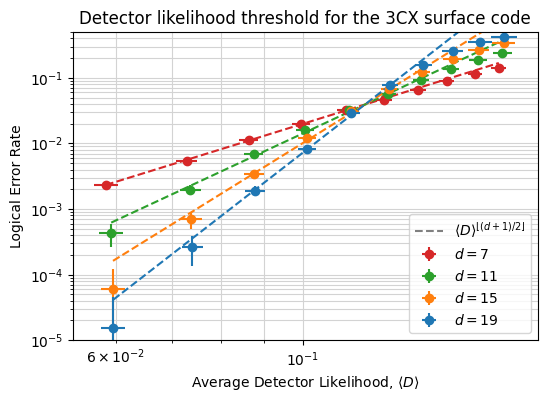

In [14]:
from scipy.optimize import minimize

DLth,PLth = minimize(fit_func,[0.1,0.05], args = (Log_fail_d_p[2],d_list,0.13), method='Nelder-Mead', tol = 1e-3).x
print(DLth,PLth)

# plt.clf()
fig, ax = plt.subplots(1, 1, figsize = (6,4))
for di,d in enumerate(d_list):
    p_list, PL_list, PL_err_list, DL_list =  np.transpose(Log_fail_d_p[2][di][1])
    num_shots = [PL/PL_err**2 if PL>0 else max_shots for PL, PL_err in zip(PL_list,PL_err_list)]
    ers,dets = PL_list,DL_list
    plt.errorbar(dets, ers, yerr=2*np.sqrt(ers*num_shots)/num_shots, xerr=2*np.sqrt(dets*num_shots)/num_shots, marker = 'o', linestyle=' ', color=f'C{len(d_list)-di-1}',label=f'$d={d}$')
    plt.plot(dets, PLth*(dets/DLth)**int((d+1)/2),'--', color=f'C{len(d_list)-di-1}')
ax.loglog()
ax.set_title('Detector likelihood threshold for the 3CX surface code')
ax.set_xlabel(r"Average Detector Likelihood, $\langle D\rangle$")
ax.set_ylabel("Logical Error Rate")
ax.grid(which='both', color='lightgray')
# if DLth is not None:
#     ax.vlines(DLth, 
#                 0, PLth, 
#                 linestyles='dashed', color='gray', alpha = 0.6,
#                 # label=r'$P_{th}$'f' = {round(100*DLth,2)}%'
#                 )
plt.axhline(1.1,linestyle = '--',c='gray', label = r'$\langle D\rangle^{\lfloor (d+1)/2 \rfloor}$')

ax.set_ylim(1e-5,.5)
ax.legend()
plt.savefig(home+"/paper_images/D_threshold_3CX.pdf")
plt.show()

## Plotting the threshold surface

In [12]:
def DL_for_noise_model(
        theta: float, phi: float,  logical: str,
        d: int = 3, error: float = 0.,
        T_over_d: float = 1, **kwargs):
    code = heavyHEX3CX(d=d, T=int(T_over_d*d), logical_observable=logical,
                                singleQerror = 0.01*error*np.cos(theta)*np.cos(phi), CXerror = error*np.cos(theta)*np.cos(phi),
                                idleerror = error*np.cos(theta)*np.sin(phi), 
                                Rerror = error*np.sin(theta),**kwargs)
    
    DL = code.detector_likelihood_from_DEM(temporal_boundaries=False,spatial_boundaries=True)
    
    return DL

In [13]:
# code, dmax, logicals, shots_lab = ['SC3', '17', ['X','Z'],'100k']
# d_inds_from,d_inds_to = 1,-2
# code, dmax, logicals, shots_lab = ['BS', '13', ['X','Z'],'8000k']
# d_inds_from,d_inds_to = 2,3
code, dmax, logicals, shots_lab = ['SC3', '13', ['X','Z'],'100k']
d_inds_from,d_inds_to = 1,-2
num_shots = 100_000

home_dir = home+'/simulations_3CX/'

# LogX_fail_3d_d_p = json.load(open(home_dir+code+'_threshold_3d_logical'+logicals[0]+'_dmax'+dmax+'_maxshots'+shots_lab+'_all.json')) 
# LogZ_fail_3d_d_p = json.load(open(home_dir+code+'_threshold_3d_logical'+logicals[1]+'_dmax'+dmax+'_maxshots'+shots_lab+'_all.json'))


LogX_fail_3d_d_p=[]
LogZ_fail_3d_d_p=[]

# d_for_DL = 0

Full_threshold_data_d_p = json.load(open(home_dir+code+'_full_threshold_plots_3d_logical'+logicals[0]+'_dmax'+dmax+'_maxshots'+shots_lab+'_all.json'))
for row in range(len(Full_threshold_data_d_p)):        
    LogX_fail_3d_d_p_col = []
    for col in range(len(Full_threshold_data_d_p[row])):
        theta1, phi1, Log_fail_d_p = Full_threshold_data_d_p[row][col]
        p_threshold, p_threshold_error,DL = 0,0,0
        try:
            p_threshold, p_threshold_error,DL = Threshold_from_LogFail(Log_fail_d_p[d_inds_from:d_inds_to+1])
        except:
            ZeroDivisionError()
        # DL=0
        # DL = DL_for_noise_model(theta=theta1,phi=phi1,logical='X',d=d_for_DL,error=p_threshold)
        LogX_fail_3d_d_p_col.append([theta1, phi1, p_threshold, p_threshold_error,DL])
    LogX_fail_3d_d_p.append(LogX_fail_3d_d_p_col)

Full_threshold_data_d_p = json.load(open(home_dir+code+'_full_threshold_plots_3d_logical'+logicals[1]+'_dmax'+dmax+'_maxshots'+shots_lab+'_all.json'))
for row in range(len(Full_threshold_data_d_p)):        
    LogZ_fail_3d_d_p_col = []
    for col in range(len(Full_threshold_data_d_p[row])):
        theta1, phi1, Log_fail_d_p = Full_threshold_data_d_p[row][col]
        try:
            p_threshold, p_threshold_error,DL = Threshold_from_LogFail(Log_fail_d_p[d_inds_from:d_inds_to+1])
        except:
            ZeroDivisionError()
        # DL = DL_for_noise_model(theta=theta1,phi=phi1,logical='Z',d=d_for_DL,error=p_threshold)
        LogZ_fail_3d_d_p_col.append([theta1, phi1, p_threshold, p_threshold_error,DL])
    LogZ_fail_3d_d_p.append(LogZ_fail_3d_d_p_col)

In [43]:
# home_dir = home+'/simulations_3CX/'
# filename = 'LogX_fail_3d_d_p_wDL_dmax'+dmax+'_maxshots'+shots_lab+'.json'
# with open(home_dir+filename, "w") as f:
#     f.write(json.dumps(LogX_fail_3d_d_p))

In [44]:
# for i,Full_threshold_data_d_p_1 in enumerate(Full_threshold_data_d_p):
#     for j,Full_threshold_data_d_p_2 in enumerate(Full_threshold_data_d_p_1):
#         print(i,j,Full_threshold_data_d_p_2[:2])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.8482214759124523 1.0603080048781208
(0.008674141115408096, 0.0006874238890761941, 0.1025181291666667)


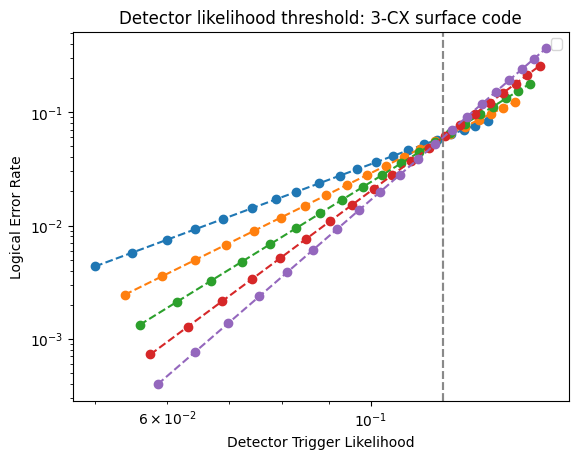

In [14]:
threshold_plot = ['DL','phys err'][0]

theta1, phi1, Log_fail_d_p = Full_threshold_data_d_p[1][2]
# theta1, phi1, Log_fail_d_p = Full_threshold_data_d_p[0][10]
print(theta1, phi1)
print(Threshold_from_LogFail(Log_fail_d_p[d_inds_from:d_inds_to+1]))
fig = plt.figure()

DLth = 0.12
PLth = 0.06
dist_list = [d for d,_ in Log_fail_d_p]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for di,d in enumerate(dist_list):
    if threshold_plot == 'phys err':
        pth = 0.00135
        PLth = 0.00045
        sim_err_list,PL_list = np.transpose(Log_fail_d_p[di][1])[[0,1]]
        plt.plot(sim_err_list,PL_list,'o',c = colors[di],label = 'd = '+str(d))
        plt.plot(sim_err_list, PLth*(sim_err_list/pth)**((d+1)/2),'--',c = colors[di])
    elif threshold_plot == 'DL':
        PL_list,DL_list = np.transpose(Log_fail_d_p[di][1])[[1,-1]]
        if code == 'BS':
            plt.plot(DL_list, PL_list,'o-',c = colors[di],label = 'd = '+str(d))
        else:
            plt.plot(DL_list, PLth*(DL_list/DLth)**((d+1)/2),'o--',c = colors[di])
            plt.axvline(DLth,linestyle = '--',c='gray', alpha = 0.4)
            # plt.axhline(1,linestyle = '--',c='gray', label = '$D^{(d+1)/2}$')
# plt.xlim(5e-2,0.16)
# plt.ylim(3e-4,0.3)
plt.legend()

# plt.grid(which = 'both', axis='x')
# plt.grid(which = 'major', axis='y')
if threshold_plot == 'DL':
    plt.title('Detector likelihood threshold: 3-CX surface code')
    plt.xlabel('Detector Trigger Likelihood')
plt.ylabel('Logical Error Rate')
plt.loglog()
# plt.savefig('Figures/3CX_detector_threshold.pdf')
plt.show()

    The BS code has no DL threshold
        - DL goes up with code distance for a given error rate

In [47]:
# %matplotlib widget

In [48]:
# dmax, shots_lab = '17', '100k'
# home_dir = home'/simulations_3CX/'

# LogX_fail_3d_d_p = json.load(open(home_dir+'LogX_fail_3d_d_p_wDL_dmax'+dmax+'_maxshots'+shots_lab+'.json'))
# LogZ_fail_3d_d_p = json.load(open(home_dir+'LogZ_fail_3d_d_p_wDL_dmax'+dmax+'_maxshots'+shots_lab+'.json'))

In [85]:
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)

def vec_below_above_threshold(vec,th_points):
    vec_norm = vec/np.linalg.norm(vec)
    #finding the closest direction
    th_overlaps = [np.dot(vec_norm,th_vec/np.linalg.norm(th_vec)) for th_vec in th_points]
    closest_th_ind = np.argmax(th_overlaps)
    th_value = np.linalg.norm(th_points[closest_th_ind])
    print(th_value,th_points[closest_th_ind])
    vec_below = np.transpose([[0,0,0],th_value*vec_norm])
    vec_above = np.transpose([th_value*vec_norm,vec])
    return vec_below,vec_above

In [91]:
threshold_points = []

for rowind in range(len(LogX_fail_3d_d_p)):
    for columnind in range(len(LogX_fail_3d_d_p[rowind])):
        theta, phi, p_threshold1, _, DL1 = LogX_fail_3d_d_p[rowind][columnind]
        theta, phi, p_threshold2, _, DL2 = LogZ_fail_3d_d_p[rowind][columnind]
        if min(p_threshold1,p_threshold2)==0:
            p_threshold1 = max(p_threshold1,p_threshold2)
            p_threshold2 = max(p_threshold1,p_threshold2)
        p_threshold = min(p_threshold1,p_threshold2)
        pR = p_threshold*np.sin(theta)
        pm = pR
        if p_threshold>0 and 0<theta<0.499*np.pi and 0<phi<0.499*np.pi and (p_threshold*np.cos(theta)*np.sin(phi) < .08):
            threshold_points.append([p_threshold*np.cos(theta)*np.cos(phi),p_threshold*np.cos(theta)*np.sin(phi),pm])
# threshold_points

In [94]:
vec_below_above_threshold([1,1,1],threshold_points)

0.006987118675474747 [0.0031191008983181313, 0.005242186383727949, 0.0034074211494231677]


(array([[0.        , 0.00403401],
        [0.        , 0.00403401],
        [0.        , 0.00403401]]),
 array([[0.00403401, 1.        ],
        [0.00403401, 1.        ],
        [0.00403401, 1.        ]]))

0.006987118675474747 [0.0031191008983181313, 0.005242186383727949, 0.0034074211494231677]
0.008530443404115818 [0.002756376795350104, 0.004922101420268042, 0.006398731846348453]
0.09389992847222228 0.20598011944444458


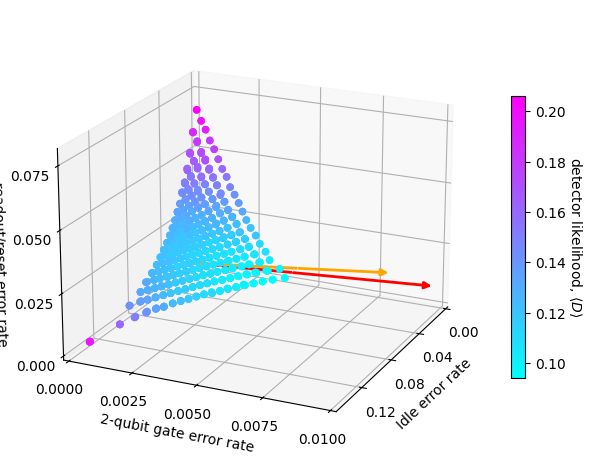

In [100]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(projection='3d')

#arrow part behind the surface
flat_vec_below, flat_vec_above = vec_below_above_threshold([.01,.01,.01],threshold_points)
sherbrooke_errors = [1.244/160.63,8.228e-3,1.200e-2]
sherb_vec_below, sherb_vec_above = vec_below_above_threshold(sherbrooke_errors,threshold_points)
ax.plot(*flat_vec_below,lw=2,color='red',zorder=-10)
ax.plot(*sherb_vec_below,lw=2,color='orange',zorder=-10)

#the surface
plot_3d_threshold(LogX_fail_3d_d_p,LogZ_fail_3d_d_p,ax=ax,cmap='cool',truncate=False, alpha=0,colbar=True)

#arrow part outside the surface
a = Arrow3D(*flat_vec_above, mutation_scale=10, 
            lw=2, arrowstyle="-|>", color="red")
b = Arrow3D(*sherb_vec_above, mutation_scale=10, 
            lw=2, arrowstyle="-|>", color="orange")
ax.add_artist(a)
ax.add_artist(b)

ax.set_xticks(np.linspace(0,0.16,5))
ax.set_yticks(np.linspace(0,0.01,5))
ax.set_zticks(np.linspace(0,0.1,5))
ax.set_ylim(0,.01)
ax.set_xlim(0,0.15)
ax.set_zlim(0,0.08)

# ax.set_xticks(np.linspace(0,0.016,5))
# ax.set_yticks(np.linspace(0,0.016,5))
# ax.set_zticks(np.linspace(0,0.016,5))
# axis_lim = .015
# ax.set_xlim(0, axis_lim)
# ax.set_ylim(0, axis_lim)
# ax.set_zlim(0, axis_lim)

# ax.set_ylim(0,.01)
# ax.set_xlim(0,.01)
# ax.set_zlim(0,.01)
ax.view_init(elev=20, azim=25)
# ax.view_init(elev=10, azim=80)
ax.set_xlabel('Idle error rate')
ax.set_ylabel('2-qubit gate error rate')
ax.set_zlabel('readout/reset error rate')

plt.tight_layout()
plt.savefig(home+'/paper_images/3CX_threshold_surface.pdf', bbox_inches = 'tight',pad_inches=0.3)
plt.show()

In [69]:
sherbrooke_errors

[0.007744506007595095, 0.008228, 0.012]

In [62]:
sherbrooke_errors

[0.007744506007595095, 0.008228, 0.012]

In [18]:
plt.violinplot(e_avgs, [1],
               showextrema=False,
               showmedians=True,)
    # [range(len(threshold_points))], e_avgs, 'o', label='e detectors', color='tab:blue')
# ax1.scatter(1, sher_e_avg, label='ibm_sherbrooke')
# ax1.scatter(1, flat_e_avg, label='flat noise model')

plt.xlabel('Noise breakdown index')
plt.ylabel('Average detector triggering rate')
plt.xticks([1], [''])
plt.ylim(.15, .21)
plt.grid()
plt.title('Detector Likelihood @ Threshold')
plt.show()

NameError: name 'e_avgs' is not defined

## Device data

    distances: 3,4
    offsets:
    dd-s: X,XX,XZX
    reset

### collecting data

In [ ]:
d=3
T=3

# offset = 2+2j #for d=2
# offset = -0+8j #for d=3
offset = -2+6j #for d=4
num_qubits = backend.num_qubits

# offset = -4+12j #for d=7

virt_link = True
anc_reset = False
logical_observable='Z'

HH3CX = heavyHEX3CX(d=d,T=T, logical_observable=logical_observable,
                    anc_reset=anc_reset, offset = offset,link_reset=False,
                    num_qubits=num_qubits)
# HH3CX_noisy = heavyHEX3CX(d=d,T=T, logical_prep=logical_prep, logical_meas=logical_meas, coherent_rot=0, anc_reset=True, CXerror=0.01,Rerror = 0.015, offset = offset, num_qubits=127)

qc = HH3CX.circuit
# qc_noisy = HH3CX_noisy.circuit

HH3CX.draw_lattice()#indices=False)

In [5]:
qc_trans = add_dynamic_decoupling(transpile(qc, backend),qubits=HH3CX.qubit_index_list,backend=backend,style = 'XZX')

In [7]:
# timeline_drawer(qc_trans,show_idle=False)

In [ ]:
d=3
anc_reset = True
num_shots = 2**14
num_qubits = backend.num_qubits
rep_delay=backend.configuration().rep_delay_range[1]

offsets_d3 = [-4+4j,-4+8j,-2+6j,0+4j,0+8j,2+6j]
dds = ['XX','XXXX','XZX']
Ts = list(range(1,7))

# offset = 0+8j #for d=3
# offset = -2+6j #for d=4
# dd = 'XZX'

res_labels = []
for offset in offsets_d3:
    for dd in dds:
        for T in Ts:
            for logical_observable in ['X','Z']:
                HH3CX = heavyHEX3CX(d=d,T=T, logical_observable=logical_observable,
                                    anc_reset=anc_reset, offset = offset,link_reset=False,
                                    num_qubits=num_qubits)
                qc = HH3CX.circuit
                qc_trans = add_dynamic_decoupling(transpile(qc, backend),qubits=HH3CX.qubit_index_list,backend=backend,style = dd)
                job=backend.run(qc_trans, shots=num_shots,rep_delay=rep_delay)
                res_labels.append([job.job_id(),
                                    'd'+str(d)
                                    +'T'+str(T)
                                    +'log'+str(logical_observable)
                                    +'_reset'+str(anc_reset)
                                    +'_os'+int((1+np.sign(offset.real))/2)*'p'+int((1-np.sign(offset.real))/2)*'m'+str(int(abs(offset.real)))+'p'+str(int(offset.imag))
                                    +'_dd'+dd
                                    +'_Nshots'+str(int(num_shots))
                                    +'_'+backend.name
                                    +'_'+job.job_id()
                                    +'.json'])
res_labels

In [429]:
res_labels

In [ ]:
folder = home+'/data_3CX/'

for job_id, file_name in res_labels:
    results = provider.retrieve_job(job_id).result().get_counts()
    result = results
    fname = folder+file_name
    with open(fname, "w") as f:
        f.write(json.dumps(result))
    print(file_name)

### Detailed analyisis of data

In [2]:
from src.heavyHEX3CX_v2 import heavyHEX3CX

In [3]:
folder = home+'/data_3CX/'
d=3
offsets = [-4+4j,-4+8j,-2+6j,0+4j,0+8j,2+6j]
dds = ['XX','XXXX','XZX']
Ts = list(range(1,7))

# folder = home+'/data_3CX/'
# d=3
# offsets = [-4+4j]
# dds = ['XZX']
# Ts = list(range(1,4))

# folder = home+'/data_3CX/'
# d=4
# offsets = [-2+6j]
# dds = ['XX','XXXX','XZX']
# Ts = list(range(1,7))


anc_reset = True
logical_observable='X'
num_shots=2**14


param_list = []
DL_list = []
LogFail_list = []
LogFail_raw_list = []

for offset in offsets:
    for dd in dds:
        for T in Ts:
            """for the sake of the detectors let's pretend that logical_prep=logical_meas, we anyway do not """
            HH3CX = heavyHEX3CX(d=d,T=T, logical_observable=logical_observable, anc_reset=anc_reset, link_reset=False, num_qubits=127)

            HH3CX_noisy = heavyHEX3CX(d=d,T=T, logical_observable=logical_observable, anc_reset=True, link_reset=False, num_qubits=127,
                                        Rerror=0.013, CXerror=0.0074)


            file_name_without_id =('d'+str(d)
                                    +'T'+str(T)
                                    +'log'+str(logical_observable)
                                    +'_reset'+str(anc_reset)
                                    +'_os'+int((1+np.sign(offset.real))/2)*'p'+int((1-np.sign(offset.real))/2)*'m'+str(int(abs(offset.real)))+'p'+str(int(offset.imag))
                                    +'_dd'+dd
                                    +'_Nshots'+str(int(num_shots)))
            for file in os.listdir(folder):
                if file.startswith(file_name_without_id):
                    result = json.load(open(folder+file))
                    print(file)

            meas_samples = []
            freqs = []

            for string,freq in result.items():
                meas_sample = np.array([int(char) for char in string[::-1]])
                meas_samples.append(meas_sample)
                freqs.append(freq)

            log_measind = [HH3CX.measuredict[(pos,T)]-((d**2-1)*T+d**2) for pos in HH3CX.edge_qubit_pos]
            detector_samples = []
            for sample in meas_samples:
                new_det_sample = []
                for detector in HH3CX.error_sensitive_events:
                    new_det_sample.append(sample[detector].sum()%2)
                new_det_sample.append(sample[log_measind].sum()%2)
                detector_samples.append(new_det_sample)

            
            qc_noisy = HH3CX_noisy.circuit
            stim_circuit = get_stim_circuits(qc_noisy)[0][0]
            for detector in HH3CX_noisy.error_sensitive_events:
                stim_circuit.append("DETECTOR",[stim.target_rec(measind-((d**2-1)*T+d**2)) for measind in detector])
            stim_circuit.append("OBSERVABLE_INCLUDE", [stim.target_rec(HH3CX_noisy.measuredict[(pos,T)]-((d**2-1)*T+d**2)) for pos in HH3CX_noisy.edge_qubit_pos],0)

            stim_DEM = stim_circuit.detector_error_model(decompose_errors=True,approximate_disjoint_errors=True,ignore_decomposition_failures=True)
            matching = src.surface_code_decoder.detector_error_model_to_pymatching_graph(stim_DEM)

            log_fails_corrected = 0
            log_fails = 0
            for sample,freq in zip(detector_samples,freqs):
                actual_observable = sample[-1]
                detectors_only = sample.copy()
                detectors_only[-1] = 0
                predicted_flip = matching.decode(detectors_only)[0]
                log_fails += freq*actual_observable
                log_fails_corrected += freq*((predicted_flip+actual_observable)%2)


            DL = HH3CX_noisy.detector_likelihood(detector_samples=detector_samples,freqs=freqs,spatial_boundaries=True,temporal_boundaries=False)

            print(DL,log_fails_corrected/num_shots,log_fails/num_shots)

            param_list.append({'d':d,'T':T,'log_obs': logical_observable,'anc_res': anc_reset,'offset': (offset.real,offset.imag),'dd': dd,'N_shots': num_shots})
            DL_list.append(DL)
            LogFail_list.append(log_fails_corrected/num_shots)
            LogFail_raw_list.append(log_fails/num_shots)

d3T1logX_resetTrue_osm4p4_ddXX_Nshots16384_ibm_sherbrooke_cnvmp9hvn4c0008a6c90.json
0.0 0.20855712890625 0.36395263671875
d3T2logX_resetTrue_osm4p4_ddXX_Nshots16384_ibm_sherbrooke_cnvmpasye0eg008p0mg0.json
0.3332977294921875 0.448974609375 0.470703125
d3T3logX_resetTrue_osm4p4_ddXX_Nshots16384_ibm_sherbrooke_cnvmpc9wsx00008wxtz0.json
0.4085845947265625 0.4871826171875 0.4864501953125
d3T4logX_resetTrue_osm4p4_ddXX_Nshots16384_ibm_sherbrooke_cnvmpds8ybr000846c90.json
0.3972066243489606 0.5009765625 0.4971923828125
d3T5logX_resetTrue_osm4p4_ddXX_Nshots16384_ibm_sherbrooke_cnvmpf9wsx00008wxtzg.json
0.40386962890625 0.49505615234375 0.4962158203125
d3T6logX_resetTrue_osm4p4_ddXX_Nshots16384_ibm_sherbrooke_cnvmph2wsx00008wxv00.json
0.4166961669921855 0.5084228515625 0.50384521484375
d3T1logX_resetTrue_osm4p4_ddXXXX_Nshots16384_ibm_sherbrooke_cnvmpja8ybr000846c9g.json
0.0 0.179443359375 0.3297119140625
d3T2logX_resetTrue_osm4p4_ddXXXX_Nshots16384_ibm_sherbrooke_cnvmpkjwsx00008wxv10.json
0.34

KeyboardInterrupt: 

In [11]:
# file_name_without_id

In [ ]:
# filename = home+'/data_3CX/Log_failX_d3_resetTrue_locs_Ts_dds.json'
# with open(filename, "w") as f:
#     f.write(json.dumps({"param_list":param_list,
#                         "DL_list":DL_list,
#                         "LogFail_list":LogFail_list,
#                         "LogFail_raw_list":LogFail_raw_list}))
# print(filename)

In [27]:
# for param, DL, LogFail in zip(param_list,DL_list,LogFail_list):
#     if param['dd']=='XXXX' and param['offset'] == -2+6j:
#         plt.plot(param['T'],LogFail,'o', label=param)
# plt.legend([(dic['offset'],dic['dd'],dic['T']) for dic in param_list])
# plt.xlim(0.4)
# plt.ylim(0.2)
# plt.show()

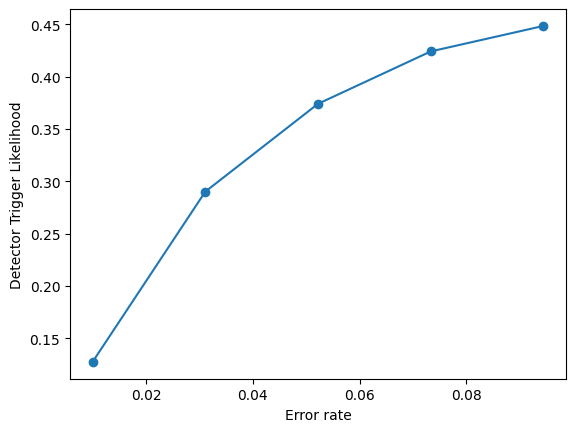

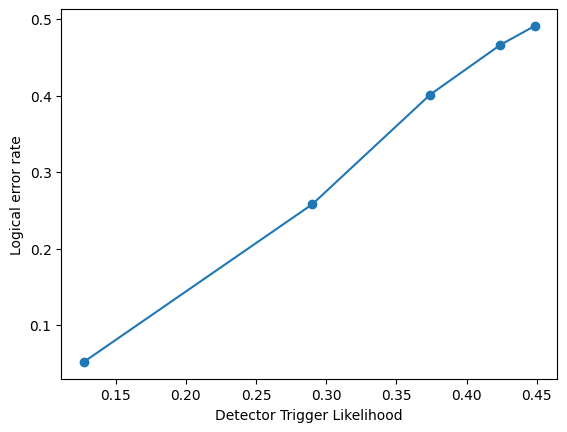

In [4]:
logical_observable='X'
d=3

# R_err_RB = 0.011
# CX_err_RB = 0.0074
# idle_err_RB = 0.02

R_err_RB = 0.01
CX_err_RB = 0.01
idle_err_RB = 0.01


phi = np.arctan2(idle_err_RB,CX_err_RB)
theta = np.arctan2(R_err_RB,np.sqrt(CX_err_RB**2+idle_err_RB**2))
# print(np.sqrt(CX_err_RB**2+idle_err_RB**2 + R_err_RB**2)*np.array([np.cos(theta)*np.cos(phi),np.cos(theta)*np.sin(phi),np.sin(theta)]))

Log_fail_sim = LogFail_of_d_p(code_circuit_class=heavyHEX3CX, theta=theta, phi=phi, logical=logical_observable,
                              dist_list=[d], error_list=np.linspace(0.01,0.2,10),
                              max_shots=2**16, shot_batch=2**10, max_num_fail=2**13,
                              T_over_d=2/d, max_fail_rate=0.49, DL=True, spatial_boundaries = True,
                              skipCX = True,
                              num_qubits=-1)

# LogFail_of_d_p(code_circuit_class=heavyHEX3CX, theta=theta, phi=phi, logical=logical_observable,
#                 dist_list=[d], error_list=[np.sqrt(CX_err_RB**2+idle_err_RB**2 + R_err_RB**2)],
#                 max_shots=2**16, shot_batch=2**10, max_num_fail=2**13,
#                 T_over_d=2/d, max_fail_rate=0.49, DL=True,
#                 num_qubits=-1)


eff_error, LF_sim, LF_raw_sim, DL_sim = np.transpose(Log_fail_sim[2][0][1])

plt.plot(eff_error,DL_sim,'o-')
plt.xlabel(r'Error rate')
plt.ylabel(r'Detector Trigger Likelihood')
plt.show()

plt.plot(DL_sim,LF_sim,'o-')
plt.ylabel(r'Logical error rate')
plt.xlabel(r'Detector Trigger Likelihood')
plt.show()

/Users/het/miniconda3/envs/DL_test/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/het/miniconda3/envs/DL_test/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


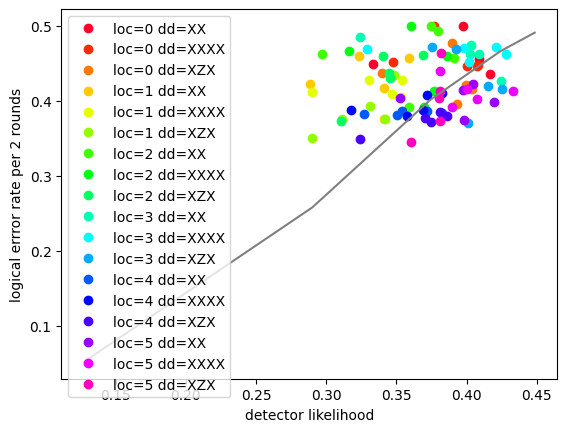

In [5]:
filename = home+'/data_3CX/Log_fail'+logical_observable+'_d3_resetTrue_locs_Ts_dds.json'
param_list,DL_list,LogFail_list,LogFail_raw_list = json.load(open(filename)).values()

offsets = [-4+4j,-4+8j,-2+6j,0+4j,0+8j,2+6j] #d=3
# offsets = [-2+6j] #d=4
dds = ['XX','XXXX','XZX']
Ts = list(range(1,7))


log_fail_rd = 2
min_T = 2 #min T run to calculate log fail rate from

cmap = plt.get_cmap('gist_rainbow')
colors = [cmap(i) for i in np.linspace(0, 1, len(dds)*len(offsets))]
for i,offset in enumerate(offsets):
    for j,dd in enumerate(dds):
        col = colors[i*len(dds)+j]
        for param, DL, LogFail in zip(param_list,DL_list,LogFail_list):
            if param['dd']==dd and complex(*param['offset']) == offset and param['T']>=min_T:
                if param['T']==d:
                    plt.plot(DL,(1-(1-2*LogFail)**(log_fail_rd/param['T']))/2,'o', color=col, label='loc='+str(i)+' dd='+param['dd'])
                else:
                    plt.plot(DL,(1-(1-2*LogFail)**(log_fail_rd/param['T']))/2,'o', color=col)
plt.legend()

# plt.plot(*np.transpose(Log_fail_sim[2][0][1]), color = 'grey')

plt.plot(DL_sim,LF_sim, color = 'grey')

# plt.xlim(0.2,0.55)
# plt.ylim(0.,0.55)
plt.xlabel('detector likelihood')
plt.ylabel('logical errror rate per '+(log_fail_rd>1)*(str(log_fail_rd)+' ')+ 'round' +(log_fail_rd>1)*'s')
plt.show()

In [ ]:
filename = home+'/data_3CX/Log_fail'+logical_observable+'_d3_resetTrue_locs_Ts_dds.json'
param_list,DL_list,LogFail_list,LogFail_raw_list = json.load(open(filename)).values()

log_fail_rd = 2


all_offsets = [-4+4j,-4+8j,-2+6j,0+4j,0+8j,2+6j]
all_dds = ['XX','XXXX','XZX']
all_Ts = list(range(1,7))

## constant location plots
plt.figure(figsize=(6*5, 4))
for pind,offsets_ in enumerate(all_offsets):
    plt.subplot(161+pind)
    offsets = [offsets_]
    dds = all_dds
    Ts = all_Ts
    min_T = 2 #min T run to calculate log fail rate from

    cmap = plt.get_cmap('gist_rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, len(dds)*len(offsets))]
    markers = min_T*['']+['^','o','*','+','s']

    for param, DL, LogFail in zip(param_list,DL_list,LogFail_list):
        if np.dot(param['offset'],[1,1j]) in offsets:
            i = offsets.index(np.dot(param['offset'],[1,1j]))
            j = dds.index(param['dd'])
            col = colors[i*len(dds)+j]
            if param['T']>=min_T:
                plt.plot(DL,(1-(1-2*LogFail)**(log_fail_rd/param['T']))/2, color=col,linestyle='None', marker=markers[param['T']], label='dd='+param['dd']+ ' T='+str(param['T']))
            plt.title('location #'+str(all_offsets.index(np.dot(param['offset'],[1,1j]))))
    plt.legend(fontsize = 7)
    plt.plot(DL_sim,LF_sim, color = 'grey')
    plt.xlabel('detector likelihood')
    plt.ylabel('logical errror rate per '+(log_fail_rd>1)*(str(log_fail_rd)+' ')+ 'round' +(log_fail_rd>1)*'s')
plt.show()


## constant T plots
plt.figure(figsize=(5.5*5, 4))
min_T = 2 #min T run to calculate log fail rate from
for pind,Ts_ in enumerate(all_Ts[all_Ts.index(min_T):]):
    plt.subplot(161+pind)
    offsets = all_offsets
    dds = all_dds
    Ts = [Ts_]

    cmap = plt.get_cmap('gist_rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, len(dds)*len(offsets))]
    markers = min_T*['']+['^','o','*','+','s']

    for param, DL, LogFail in zip(param_list,DL_list,LogFail_list):
        if param['T'] in Ts:
            i = offsets.index(np.dot(param['offset'],[1,1j]))
            j = dds.index(param['dd'])
            col = colors[i*len(dds)+j]
            if param['T']>=min_T:
                plt.plot(DL,(1-(1-2*LogFail)**(log_fail_rd/param['T']))/2, color=col,linestyle='None', marker=markers[param['T']], label='loc='+str(all_offsets.index(np.dot(param['offset'],[1,1j])))+' dd='+param['dd'])
                plt.title('T='+str(param['T']))
    plt.legend(fontsize = 7)
    plt.plot(DL_sim,LF_sim, color = 'grey')
    plt.xlabel('detector likelihood')
    plt.ylabel('logical errror rate per '+(log_fail_rd>1)*(str(log_fail_rd)+' ')+ 'round' +(log_fail_rd>1)*'s')
plt.show()

## constant dd plots
plt.figure(figsize=(3.5*5, 4))
for pind,dds_ in enumerate(all_dds):
    plt.subplot(141+pind)
    offsets = all_offsets
    dds = [dds_]
    Ts = all_Ts
    min_T = 2 #min T run to calculate log fail rate from

    cmap = plt.get_cmap('gist_rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, len(dds)*len(offsets))]
    markers = min_T*['']+['^','o','*','+','s']

    for param, DL, LogFail in zip(param_list,DL_list,LogFail_list):
        if param['dd'] in dds:
            i = offsets.index(np.dot(param['offset'],[1,1j]))
            j = dds.index(param['dd'])
            col = colors[i*len(dds)+j]
            if param['T']>=min_T:
                plt.plot(DL,(1-(1-2*LogFail)**(log_fail_rd/param['T']))/2, color=col,linestyle='None', marker=markers[param['T']], label='loc='+str(all_offsets.index(np.dot(param['offset'],[1,1j]))) + ' T='+str(param['T']))
            plt.title('dd='+param['dd'])
    plt.legend(fontsize = 5)
    plt.plot(DL_sim,LF_sim, color = 'grey')
    plt.xlabel('detector likelihood')
    plt.ylabel('logical errror rate per '+(log_fail_rd>1)*(str(log_fail_rd)+' ')+ 'round' +(log_fail_rd>1)*'s')
plt.show()

### sherbrooke (3CX multiple locations) and torino (3CX and BS from the logical Bell-state project) data

In [6]:
from src.utils import string2detections

home = os.getcwd()

In [7]:
from scipy.optimize import curve_fit, minimize
from math import comb

def DLfit(peff,alpha):
    # return 0.5*(1-(1-2*peff)**alpha)
    return 0.5*(1-np.exp(-alpha*peff))

def DLfit_inv(DL,alpha):
    def root_eq(x):
        return abs(DLfit(peff=x,alpha=alpha)-DL)
    opt_res = minimize(root_eq,x0=0.25, method='Nelder-Mead',tol=1e-5,options={'disp':False})
    peff_opt = opt_res.x[0]
    if opt_res.success and 0<peff_opt<0.5:
        return peff_opt
    else:
        return -1

def discount_LogFail(LF, T_init, T_fin):
    if T_init != T_fin:
        LF_per_round = (1-abs(1-2*LF)**(1/T_init))/2
        LF_Tfin = sum([comb(T_fin,k)*LF_per_round**k*(1-LF_per_round)**(T_fin-k) for k in range(T_fin+1) if k%2==1])
    else:
        LF_Tfin = LF
    return LF_Tfin

def discount_LogFail_err(LF, LF_err, T_init, T_fin):
    LF_err_Tfin = abs(discount_LogFail(LF+LF_err,T_init, T_fin) - discount_LogFail(LF-LF_err, T_init, T_fin))/2

    return LF_err_Tfin

def LE_func_Trounds(T, LEpR):
    return (1-(1-2*LEpR)**T)/2

def fit_LE_per_round(T_list, LE_list, input_per_round = True):
    if input_per_round:
        LE_list2 = []
        for T,LE in zip(T_list, LE_list):
            LE_list2.append(discount_LogFail(LE,1,T))
    else:
        LE_list2 = LE_list
    
    popt, _ = curve_fit(LE_func_Trounds, T_list, LE_list2, bounds = (0,0.5))
    return popt[0]


#### generating data

In [8]:
folder = home+'/data_3CX/'
backend = provider.get_backend('ibm_sherbrooke')
date = datetime(year=2023, month=12, day=12)
postfix = '_resetTrue'
dds = ['XX','XXXX','XZX']
offsets = [-4+4j,-4+8j,0+4j,0+8j,2+6j,-2+6j,-2+6j]
d_list = [3,3,3,3,3,3,4]
T_list = list(range(2,7))
num_shots = 2**14
CXerror, Rerror,singleQerror, idleerror = 0.008, 0.012, 3e-4, 1.5/120
CodeClass = heavyHEX3CX_b
plot_title = r'3CX code, ibm-sherbrooke'

phi = np.arctan2(idleerror,CXerror)
theta = np.arctan2(Rerror,np.sqrt(CXerror**2+idleerror**2))
min_T = 2

LF_exp_d = []
LF_sim_d = []
LF_sim_avg_d = []
LF_sim_calib_d = []
param_d = []
DL_d = []
for d,offset in zip(d_list,offsets):
    for dd in dds:
        #extract logical error rate and detector likelihoods
        log_fail_rd = 1 #d
        param_list = []
        DL_list = []
        LogFail_list = []
        LogFail_err_list = []
        LogFail_raw_list = []
        Log_fail_T =[]
        for T in T_list:
            for logical_observable in ['X','Z']:
                code = CodeClass(d=d, T=T, logical_observable=logical_observable,
                                CXerror=CXerror, Rerror=Rerror,singleQerror=singleQerror,idleerror=idleerror)
                file_name_without_id =('d' + str(d) + 'T' + str(T) + 'log'+logical_observable+postfix+
                                        '_os'+int((1+np.sign(offset.real))/2)*'p'+int((1-np.sign(offset.real))/2)*'m'+str(int(abs(offset.real)))+'p'+str(int(offset.imag))+
                                        '_dd'+dd+'_')

                for file in os.listdir(folder):
                    if file.startswith(file_name_without_id):
                        result = json.load(open(folder+file))
                        print(file)
                meas_data = code.measuredict
                edge_qubits = code.edge_qubit_pos
                log_measinds = [[meas_data[(pos,T)]-len(meas_data) for pos in edge_qubits]]
                freqs,detector_samples = string2detections(job_result = result, det_measinds = code.error_sensitive_events, log_measinds = log_measinds)
                stim_DEM = code.stim_circuit.detector_error_model(decompose_errors=True,approximate_disjoint_errors=True,ignore_decomposition_failures=True)
                matching = src.surface_code_decoder.detector_error_model_to_pymatching_graph(stim_DEM)
                log_fails_corrected = 0
                log_fails = 0
                for sample,freq in zip(detector_samples,freqs):
                    actual_observable = sample[-1]
                    detectors_only = sample.copy()
                    detectors_only[-1] = 0
                    predicted_flip = matching.decode(detectors_only)[0]
                    log_fails += freq*actual_observable
                    log_fails_corrected += freq*((predicted_flip+actual_observable)%2)
                DL = code.detector_likelihood(detector_samples=detector_samples,freqs=freqs,spatial_boundaries=True,temporal_boundaries=False)
                param_list.append({'d':d,'T':T,'log_obs': logical_observable,'anc_res':True,'offset': offset,'dd': dd,'N_shots': num_shots})
                DL_list.append(DL)
                LogFail_list.append(log_fails_corrected/num_shots)
                LogFail_err_list.append(np.sqrt(log_fails_corrected)/num_shots)
                LogFail_raw_list.append(log_fails/num_shots)
                print(DL,log_fails_corrected/num_shots,log_fails/num_shots)

        # calculate logical error rate vs detector likelihood
        Log_fail_sim = LogFail_of_d_p(code_circuit_class=CodeClass, theta=theta, phi=phi, 
                                    logical='Z', #logical only metters if the singleQerror is high 
                                    dist_list=[d], error_list=np.linspace(0.01,0.5,10),
                                    max_shots=300_000, shot_batch=2**10, max_num_fail=2**13,
                                    T_over_d=1, max_fail_rate=1, DL=True,
                                    spatial_boundaries = True,
                                    num_qubits=-1)
        eff_error, _, _, DL_sim = np.transpose(Log_fail_sim[2][0][1])

        #fitting function for the detector likelihood vs logical error rate
        popt,pcov = curve_fit(DLfit,eff_error,DL_sim)
        print('optimal alpha = ',popt,'+/-',np.sqrt(np.diag(pcov))[0])
        
        # plt.plot(eff_error,DL_sim, '*')
        # xs = np.linspace(0,0.5,30)
        # plt.plot(xs,DLfit(xs,popt))
        plt.plot(0.5*(1-2*eff_error),0.5-DL_sim, '*')
        xs = np.linspace(0,0.5,30)
        plt.plot(0.5*(1-2*xs),0.5-DLfit(xs,popt))
        # plt.loglog()
        plt.yscale('log')
        plt.ylim(1e-3,1)

        plt.title(plot_title)
        plt.xlabel(r'effective error rate $p_{eff}$')
        plt.ylabel(r'detector likelihood')
        plt.show()

        #plotting simulation vs data
        cmap = plt.get_cmap('gist_rainbow')
        colors = [cmap(i) for i in np.linspace(0, 1, 2*len(T_list))]
        # calculate logical error rate vs detector likelihood
        error_list = [DLfit_inv(DL,popt) for DL in np.linspace(0.1,0.49,10)]
        Log_fail_sim = LogFail_of_d_p(code_circuit_class=CodeClass, theta=theta, phi=phi, 
                                    logical='Z', #logical only metters if the singleQerror is high 
                                    dist_list=[d], error_list=error_list,
                                    max_shots=2**16, shot_batch=2**10, max_num_fail=2**13,
                                    T_over_d=1, max_fail_rate=1, DL=True,
                                    spatial_boundaries = True,
                                    num_qubits=-1)
        _, LF_sim, LF_sim_err, DL_sim = np.transpose(Log_fail_sim[2][0][1])
        LogFail_Tround = []
        LogFail_Tround_err = []
        for param, DL, LogFail, LF_err in zip(param_list,DL_list,LogFail_list,LogFail_err_list):
            if param['T']>=min_T:
                LogFail_Tround.append(discount_LogFail(LogFail,param['T'],log_fail_rd))
                LogFail_Tround_err.append(discount_LogFail_err(LogFail,LF_err,param['T'],log_fail_rd))
                plt.plot(DL,discount_LogFail(LogFail,param['T'],log_fail_rd),'o',
                        color=colors[((param['T']-2)*2+(param['log_obs']=='Z'))],
                        label='T='+str(param['T'])+' log-'+str(param['log_obs']))
        plt.legend()
        plt.plot(DL_sim,[discount_LogFail(LF,d,log_fail_rd) for LF in LF_sim], '.-',color = 'grey')
        plt.title(plot_title+' d = '+str(d))
        plt.xlabel(r'detector likelihood')
        plt.ylabel(r'logical error rate per '+(log_fail_rd>1)*(str(log_fail_rd)+' ')+ r'round' +(log_fail_rd>1)*'s')
        plt.show()

        LF_exp_d.append(np.transpose([LogFail_Tround,LogFail_Tround_err]).tolist())
        param_d.append(param_list)
        DL_d.append(DL_list)

        #calculating measured vs simulated Log fail
        LF_sim_list = []
        LF_sim_avg_list = []
        LF_sim_calib_list = []
        for DL in DL_list:
            peff = DLfit_inv(DL,popt)

            Log_fail_sim = Log_fail_error_model(code_circuit_class=CodeClass, d = d, T = d, logical=logical_observable,
                                                singleQerror = peff*np.cos(theta)*np.cos(phi),
                                                CXerror = peff*np.cos(theta)*np.cos(phi),
                                                idleerror = peff*np.cos(theta)*np.sin(phi), 
                                                Rerror = peff*np.sin(theta),
                                                max_shots=2**16, shot_batch=2**10, max_num_fail=2**13,
                                                LF_error = True, DL = True,
                                                spatial_boundaries = True,
                                                num_qubits=-1)

            noise_dict = get_noise_dict_from_backend(backend, date=date)
            Log_fail_calib_sim = Log_fail_error_model(code_circuit_class=CodeClass, d = d, T = d, logical=logical_observable,
                                                    CXerror = 0, Rerror = 0, singleQerror = 0, idleerror = 0,
                                                    noise_dict = noise_dict,
                                                    max_shots=2**16, shot_batch=2**10, max_num_fail=2**13,
                                                    LF_error = True, DL = False,
                                                    #kwargs for code:
                                                    spatial_boundaries = True,
                                                    num_qubits = backend.num_qubits, offset = offset)

            qubits_in_code = [code.heavyHEX_dict[q_pos] for q_pos in code.q2i.keys()]+[code.heavyHEX_dict[q_pos] for q_pos in code.a2i.keys()] #qubits and ancillas
            avg_Rerror = np.mean([(noise_dict[q]['init']+noise_dict[q]['RO'])/2 for q in qubits_in_code]) #readout and reset error rates are the same anyway
            avg_singleQerror = np.mean([noise_dict[q]['gate'] for q in qubits_in_code])
            avg_CXerror = np.mean([np.mean(list(noise_dict[q]['2-gate'].values())) for q in qubits_in_code])
            avg_idleerror = np.mean([noise_dict[q]['idle'] for q in qubits_in_code])
            Log_fail_avg_sim = Log_fail_error_model(code_circuit_class=CodeClass, d = d, T = d, logical=logical_observable,
                                                    CXerror = avg_CXerror, Rerror = avg_Rerror, singleQerror = avg_singleQerror, idleerror = avg_idleerror,
                                                    max_shots=2**16, shot_batch=2**10, max_num_fail=2**13,
                                                    LF_error = True, DL = False,
                                                    spatial_boundaries = True,
                                                    num_qubits=-1)


            LF_sim, LF_sim_err, DL_sim = Log_fail_sim
            LF_sim, LF_sim_err = discount_LogFail(LF_sim,d,log_fail_rd),discount_LogFail_err(LF_sim,LF_sim_err,d,log_fail_rd)
            LF_sim_avg, LF_sim_avg_err = Log_fail_avg_sim
            LF_sim_avg, LF_sim_avg_err = discount_LogFail(LF_sim_avg,d,log_fail_rd),discount_LogFail_err(LF_sim_avg,LF_sim_avg_err,d,log_fail_rd)
            LF_sim_calib, LF_sim_calib_err = Log_fail_calib_sim
            LF_sim_calib, LF_sim_calib_err = discount_LogFail(LF_sim_calib,d,log_fail_rd),discount_LogFail_err(LF_sim_calib,LF_sim_calib_err,d,log_fail_rd)
            if abs((DL-DL_sim)/DL)>0.05:
                print('simulated detector likelihood deviates from measured ',(DL,DL_sim))
            LF_sim_list.append([LF_sim, LF_sim_err])
            LF_sim_avg_list.append([LF_sim_avg,LF_sim_avg_err])
            LF_sim_calib_list.append([LF_sim_calib,LF_sim_calib_err])
        LF_sim_d.append(LF_sim_list)
        LF_sim_avg_d.append(LF_sim_avg_list)
        LF_sim_calib_d.append(LF_sim_calib_list)

LF_exp_d_err = np.array(LF_exp_d)[:,:,1]
LF_exp_d = np.array(LF_exp_d)[:,:,0]
LF_sim_d_err = np.array(LF_sim_d)[:,:,1]
LF_sim_d = np.array(LF_sim_d)[:,:,0]
LF_sim_avg_d_err = np.array(LF_sim_avg_d)[:,:,1]
LF_sim_avg_d = np.array(LF_sim_avg_d)[:,:,0]
LF_sim_calib_d_err = np.array(LF_sim_calib_d)[:,:,1]
LF_sim_calib_d = np.array(LF_sim_calib_d)[:,:,0]

NameError: name 'provider' is not defined

In [192]:
# with open(home+"/simulation_data/sim_method_comparicon_3CX.obj", "wb") as input_file:
#     pickle.dump({'LF_exp_d':LF_exp_d,'LF_exp_d_err':LF_exp_d_err,
#                  'LF_sim_d':LF_sim_d,'LF_sim_d_err':LF_sim_d_err,
#                  'LF_sim_avg_d':LF_sim_avg_d,'LF_sim_avg_d_err':LF_sim_avg_d_err,
#                  'LF_sim_calib_d':LF_sim_calib_d,'LF_sim_calib_d_err':LF_sim_calib_d_err,
#                  'param_d':param_d, 'DL_d':DL_d
#                  }
#                  , input_file)

d3T2logX_resetTrue_osm4p4_ddXX_Nshots16384_ibm_sherbrooke_cnvmpasye0eg008p0mg0.json
0.3332977294921875 0.4481201171875 0.470703125
d3T3logX_resetTrue_osm4p4_ddXX_Nshots16384_ibm_sherbrooke_cnvmpc9wsx00008wxtz0.json
0.4085845947265625 0.48760986328125 0.4864501953125
d3T4logX_resetTrue_osm4p4_ddXX_Nshots16384_ibm_sherbrooke_cnvmpds8ybr000846c90.json
0.3972066243489606 0.4986572265625 0.4971923828125
d3T5logX_resetTrue_osm4p4_ddXX_Nshots16384_ibm_sherbrooke_cnvmpf9wsx00008wxtzg.json
0.40386962890625 0.49755859375 0.4962158203125
d3T6logX_resetTrue_osm4p4_ddXX_Nshots16384_ibm_sherbrooke_cnvmph2wsx00008wxv00.json
0.4166961669921855 0.50628662109375 0.50384521484375
optimal alpha =  [22.76258205] +/- 0.5476379530518605


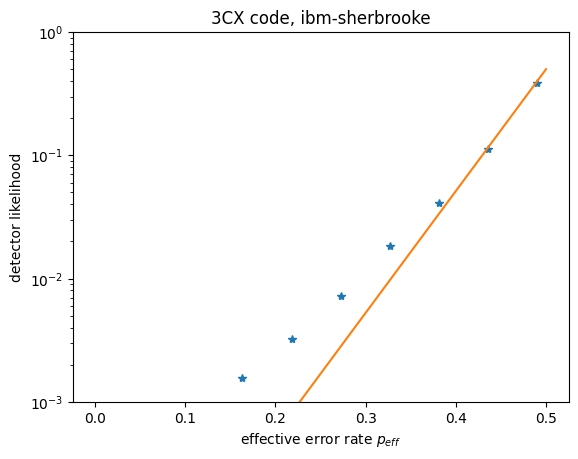

d3T2logZ_resetTrue_osm4p4_ddXX_Nshots16384_ibm_sherbrooke_cnvmpbhwsx00008wxtyg.json
0.3301544189453125 0.24603271484375 0.3740234375
d3T3logZ_resetTrue_osm4p4_ddXX_Nshots16384_ibm_sherbrooke_cnvmpd1vn4c0008a6ca0.json
0.39839935302734375 0.3389892578125 0.419189453125
d3T4logZ_resetTrue_osm4p4_ddXX_Nshots16384_ibm_sherbrooke_cnvmpehgpnkg0084360g.json
0.38620503743489626 0.411865234375 0.50372314453125
d3T5logZ_resetTrue_osm4p4_ddXX_Nshots16384_ibm_sherbrooke_cnvmpg2vn4c0008a6cag.json
0.4056205749511719 0.43072509765625 0.49859619140625
d3T6logZ_resetTrue_osm4p4_ddXX_Nshots16384_ibm_sherbrooke_cnvmphtgpnkg00843610.json
0.3954620361328101 0.44366455078125 0.47845458984375
optimal alpha =  [22.37359029] +/- 0.6131197017694902


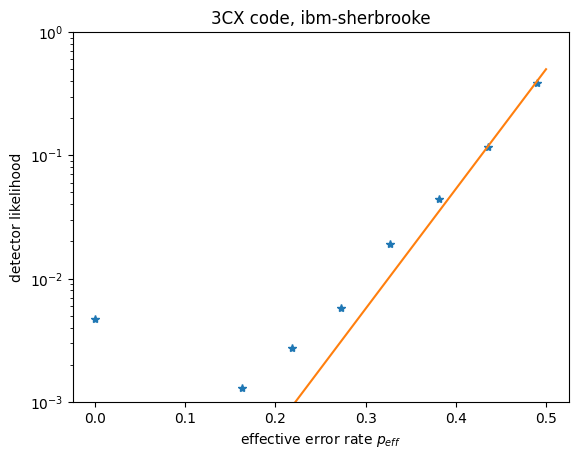

In [63]:


folder = home+'/data_3CX/'
backend = provider.get_backend('ibm_sherbrooke')
date = datetime(year=2023, month=12, day=12)
postfix = '_resetTrue'
dds = ['XX','XXXX','XZX'][:1]
offsets = [-4+4j,-4+8j,0+4j,0+8j,2+6j,-2+6j,-2+6j][:1]
d_list = [3,3,3,3,3,3,4][:1]
T_list = list(range(2,7))
num_shots = 2**14
CXerror, Rerror,singleQerror, idleerror = 0.008, 0.012, 3e-4, 1.5/120
CodeClass = heavyHEX3CX_b
plot_title = r'3CX code, ibm-sherbrooke'


phi = np.arctan2(idleerror,CXerror)
theta = np.arctan2(Rerror,np.sqrt(CXerror**2+idleerror**2))
min_T = 2

LF_exp_d = []
LF_sim_d = []
LF_sim_avg_d = []
LF_sim_calib_d = []
param_d = []
DL_d = []
for d,offset in zip(d_list,offsets):
    for dd in dds:
        for logical_observable in ['X','Z']:
            #extract logical error rate and detector likelihoods
            log_fail_rd = 1 #d
            param_list = []
            DL_list = []
            LogFail_list = []
            LogFail_err_list = []
            LogFail_raw_list = []
            Log_fail_T =[]
            for T in T_list:
                code = CodeClass(d=d, T=T, logical_observable=logical_observable,
                                CXerror=CXerror, Rerror=Rerror,singleQerror=singleQerror,idleerror=idleerror)
                file_name_without_id =('d' + str(d) + 'T' + str(T) + 'log'+logical_observable+postfix+
                                    '_os'+int((1+np.sign(offset.real))/2)*'p'+int((1-np.sign(offset.real))/2)*'m'+str(int(abs(offset.real)))+'p'+str(int(offset.imag))+
                                    '_dd'+dd+'_')

                for file in os.listdir(folder):
                    if file.startswith(file_name_without_id):
                        result = json.load(open(folder+file))
                        print(file)
                meas_data = code.measuredict
                edge_qubits = code.edge_qubit_pos
                log_measinds = [[meas_data[(pos,T)]-len(meas_data) for pos in edge_qubits]]
                freqs,detector_samples = string2detections(job_result = result, det_measinds = code.error_sensitive_events, log_measinds = log_measinds)
                stim_DEM = code.stim_circuit.detector_error_model(decompose_errors=True,approximate_disjoint_errors=True,ignore_decomposition_failures=True)
                matching = src.surface_code_decoder.detector_error_model_to_pymatching_graph(stim_DEM)
                log_fails_corrected = 0
                log_fails = 0
                for sample,freq in zip(detector_samples,freqs):
                    actual_observable = sample[-1]
                    detectors_only = sample.copy()
                    detectors_only[-1] = 0
                    predicted_flip = matching.decode(detectors_only)[0]
                    log_fails += freq*actual_observable
                    log_fails_corrected += freq*((predicted_flip+actual_observable)%2)
                DL = code.detector_likelihood(detector_samples=detector_samples,freqs=freqs,spatial_boundaries=True,temporal_boundaries=False)
                param_list.append({'d':d,'T':T,'log_obs': logical_observable,'anc_res':True,'offset': offset,'dd': dd,'N_shots': num_shots})
                DL_list.append(DL)
                LogFail_list.append(log_fails_corrected/num_shots)
                LogFail_err_list.append(np.sqrt(log_fails_corrected)/num_shots)
                LogFail_raw_list.append(log_fails/num_shots)
                print(DL,log_fails_corrected/num_shots,log_fails/num_shots)


            # calculate logical error rate vs detector likelihood
            Log_fail_sim = LogFail_of_d_p(code_circuit_class=CodeClass, theta=theta, phi=phi, 
                                        logical=logical_observable, #logical only metters if the singleQerror is high 
                                        dist_list=[d], error_list=np.linspace(0.01,0.5,10),
                                        max_shots=10_000, shot_batch=2**10, max_num_fail=10_000,
                                        T_over_d=1, max_fail_rate=1, DL=True,
                                        spatial_boundaries = True,
                                        num_qubits=-1)
            eff_error, _, _, DL_sim = np.transpose(Log_fail_sim[2][0][1])

            #fitting function for the detector likelihood vs logical error rate
            popt,pcov = curve_fit(DLfit,eff_error,DL_sim)
            print('optimal alpha = ',popt,'+/-',np.sqrt(np.diag(pcov))[0])
            
            plt.plot(eff_error,DL_sim, '*')
            xs = np.linspace(0,0.5,30)
            plt.plot(xs,DLfit(xs,popt))
            plt.ylim(0,0.6)

            plt.title(plot_title)
            plt.xlabel(r'effective error rate $p_{eff}$')
            plt.ylabel(r'detector likelihood')
            plt.show()

            #plotting simulation vs data
            cmap = plt.get_cmap('gist_rainbow')
            colors = [cmap(i) for i in np.linspace(0, 1, 2*len(T_list))]
            # calculate logical error rate vs detector likelihood
            error_list = [DLfit_inv(DL,popt) for DL in np.linspace(0.1,0.49,10)]
            Log_fail_sim = LogFail_of_d_p(code_circuit_class=CodeClass, theta=theta, phi=phi, 
                                        logical=logical_observable, #logical only metters if the singleQerror is high 
                                        dist_list=[d], error_list=error_list,
                                        max_shots=2**16, shot_batch=2**10, max_num_fail=2**13,
                                        T_over_d=1, max_fail_rate=1, DL=True,
                                        spatial_boundaries = True,
                                        num_qubits=-1)
            _, LF_sim, LF_sim_err, DL_sim = np.transpose(Log_fail_sim[2][0][1])
            LogFail_Tround = []
            LogFail_Tround_err = []
            for param, DL, LogFail, LF_err in zip(param_list,DL_list,LogFail_list,LogFail_err_list):
                if param['T']>=min_T:
                    LogFail_Tround.append(discount_LogFail(LogFail,param['T'],log_fail_rd))
                    LogFail_Tround_err.append(discount_LogFail_err(LogFail,LF_err,param['T'],log_fail_rd))
                    plt.plot(DL,discount_LogFail(LogFail,param['T'],log_fail_rd),'o',
                            color=colors[((param['T']-2)*2+(param['log_obs']=='Z'))],
                            label='T='+str(param['T'])+' log-'+str(param['log_obs']))
            plt.legend()
            plt.plot(DL_sim,[discount_LogFail(LF,d,log_fail_rd) for LF in LF_sim], '.-',color = 'grey')
            plt.title(plot_title+' d = '+str(d))
            plt.xlabel(r'detector likelihood')
            plt.ylabel(r'logical error rate per '+(log_fail_rd>1)*(str(log_fail_rd)+' ')+ r'round' +(log_fail_rd>1)*'s')
            plt.show()

            LF_exp_d.append(np.transpose([LogFail_Tround,LogFail_Tround_err]).tolist())
            param_d.append(param_list)
            DL_d.append(DL_list)

            #calculating measured vs simulated Log fail
            LF_sim_list = []
            LF_sim_avg_list = []
            LF_sim_calib_list = []
            for T in T_list:
                peff = DLfit_inv(DL_list[-1],popt) #DL from the longest run (most accurate)

                Log_fail_sim = Log_fail_error_model(code_circuit_class=CodeClass, d = d, T = T, logical=logical_observable,
                                                    singleQerror = peff*np.cos(theta)*np.cos(phi),
                                                    CXerror = peff*np.cos(theta)*np.cos(phi),
                                                    idleerror = peff*np.cos(theta)*np.sin(phi), 
                                                    Rerror = peff*np.sin(theta),
                                                    max_shots=2**16, shot_batch=2**10, max_num_fail=2**13,
                                                    LF_error = True, DL = True,
                                                    spatial_boundaries = True,
                                                    num_qubits=-1)

                noise_dict = get_noise_dict_from_backend(backend, date=date)
                Log_fail_calib_sim = Log_fail_error_model(code_circuit_class=CodeClass, d = d, T = T, logical=logical_observable,
                                                        CXerror = 0, Rerror = 0, singleQerror = 0, idleerror = 0,
                                                        noise_dict = noise_dict,
                                                        max_shots=2**16, shot_batch=2**10, max_num_fail=2**13,
                                                        LF_error = True, DL = False,
                                                        spatial_boundaries = True,
                                                        #kwargs for code:
                                                        num_qubits = backend.num_qubits, offset = offset)

                qubits_in_code = [code.heavyHEX_dict[q_pos] for q_pos in code.q2i.keys()]+[code.heavyHEX_dict[q_pos] for q_pos in code.a2i.keys()] #qubits and ancillas
                avg_Rerror = np.mean([(noise_dict[q]['init']+noise_dict[q]['RO'])/2 for q in qubits_in_code]) #readout and reset error rates are the same anyway
                avg_singleQerror = np.mean([noise_dict[q]['gate'] for q in qubits_in_code])
                avg_CXerror = np.mean([np.mean(list(noise_dict[q]['2-gate'].values())) for q in qubits_in_code])
                avg_idleerror = np.mean([noise_dict[q]['idle'] for q in qubits_in_code])
                Log_fail_avg_sim = Log_fail_error_model(code_circuit_class=CodeClass, d = d, T = T, logical=logical_observable,
                                                        CXerror = avg_CXerror, Rerror = avg_Rerror, singleQerror = avg_singleQerror, idleerror = avg_idleerror,
                                                        max_shots=2**16, shot_batch=2**10, max_num_fail=2**13,
                                                        LF_error = True, DL = False,
                                                        spatial_boundaries = True,
                                                        num_qubits=-1)


                LF_sim, LF_sim_err, DL_sim = Log_fail_sim
                LF_sim, LF_sim_err = discount_LogFail(LF_sim,T,log_fail_rd),discount_LogFail_err(LF_sim,LF_sim_err,T,log_fail_rd)
                LF_sim_avg, LF_sim_avg_err = Log_fail_avg_sim
                LF_sim_avg, LF_sim_avg_err = discount_LogFail(LF_sim_avg,T,log_fail_rd),discount_LogFail_err(LF_sim_avg,LF_sim_avg_err,T,log_fail_rd)
                LF_sim_calib, LF_sim_calib_err = Log_fail_calib_sim
                LF_sim_calib, LF_sim_calib_err = discount_LogFail(LF_sim_calib,T,log_fail_rd),discount_LogFail_err(LF_sim_calib,LF_sim_calib_err,T,log_fail_rd)
                if abs((DL-DL_sim)/DL)>0.05:
                    print('simulated detector likelihood deviates from measured ',(DL,DL_sim))
                LF_sim_list.append([LF_sim, LF_sim_err])
                LF_sim_avg_list.append([LF_sim_avg,LF_sim_avg_err])
                LF_sim_calib_list.append([LF_sim_calib,LF_sim_calib_err])
            LF_sim_d.append(LF_sim_list)
            LF_sim_avg_d.append(LF_sim_avg_list)
            LF_sim_calib_d.append(LF_sim_calib_list)

LF_exp_d_err = np.array(LF_exp_d)[:,:,1]
LF_exp_d = np.array(LF_exp_d)[:,:,0]
LF_sim_d_err = np.array(LF_sim_d)[:,:,1]
LF_sim_d = np.array(LF_sim_d)[:,:,0]
LF_sim_avg_d_err = np.array(LF_sim_avg_d)[:,:,1]
LF_sim_avg_d = np.array(LF_sim_avg_d)[:,:,0]
LF_sim_calib_d_err = np.array(LF_sim_calib_d)[:,:,1]
LF_sim_calib_d = np.array(LF_sim_calib_d)[:,:,0]

In [30]:
# with open(home+"/simulation_data/sim_method_comparicon_3CX_v2.obj", "wb") as input_file:
#     pickle.dump({'LF_exp_d':LF_exp_d,'LF_exp_d_err':LF_exp_d_err,
#                  'LF_sim_d':LF_sim_d,'LF_sim_d_err':LF_sim_d_err,
#                  'LF_sim_avg_d':LF_sim_avg_d,'LF_sim_avg_d_err':LF_sim_avg_d_err,
#                  'LF_sim_calib_d':LF_sim_calib_d,'LF_sim_calib_d_err':LF_sim_calib_d_err,
#                  'param_d':param_d, 'DL_d':DL_d
#                  }
#                  , input_file)

#### plotting data

In [8]:
with open(home+"/simulation_data/sim_method_comparicon_3CX_v2.obj", "rb") as input_file:
    LF_exp_d,LF_exp_d_err,LF_sim_d,LF_sim_d_err,LF_sim_avg_d,LF_sim_avg_d_err,LF_sim_calib_d,LF_sim_calib_d_err,param_d,DL_d = list(pickle.load(input_file).values())

Effective-p 0.30962640755148374
Average -0.14976982657078902
Calibration 0.07651998536260811


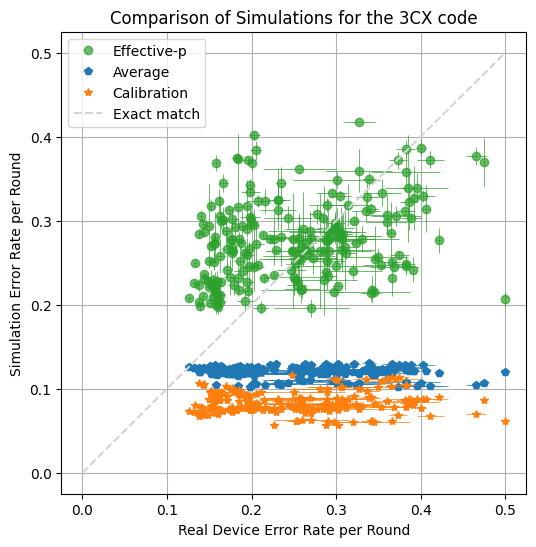

In [9]:
p_eff_points = [np.array(LF_exp_d).flatten(),np.array(LF_sim_d).flatten(),np.array(LF_exp_d_err).flatten(),np.array(LF_sim_d_err).flatten()]
avg_points = [np.array(LF_exp_d).flatten(),np.array(LF_sim_avg_d).flatten(),np.array(LF_exp_d_err).flatten(),np.array(LF_sim_avg_d_err).flatten()]
calib_points = [np.array(LF_exp_d).flatten(),np.array(LF_sim_calib_d).flatten(),np.array(LF_exp_d_err).flatten(),np.array(LF_sim_calib_d_err).flatten()]

plt.figure(figsize=(6,6))
data_sets = [p_eff_points, avg_points, calib_points]
shapes = ['o', 'p', '*']
alphas = [.7, 1, 1]
labels = ['Effective-p', 'Average', 'Calibration']
for c in range(3):
    real_data, sim_data, real_error, sim_error = data_sets[c]

    print(f"{labels[c]}", np.corrcoef(real_data,sim_data)[0,1])

    plt.plot(real_data, sim_data, shapes[c], color=f'C{(c+2)%3}', label=f"{labels[c]}", alpha=alphas[c])
    plt.errorbar(real_data, sim_data, xerr = real_error, yerr = sim_error, linestyle=' ', color=f'C{(c+2)%3}', linewidth=.5)

plt.plot(np.linspace(0, .5, 100), np.linspace(0, .5, 100), '--', color='lightgrey', label='Exact match')
plt.ylabel('Simulation Error Rate per Round')
plt.xlabel('Real Device Error Rate per Round')
plt.title(f'Comparison of Simulations for the 3CX code')
# plt.xlim(.11, .26)
# plt.ylim(.03, .25)
plt.grid(which='both')
plt.legend()
# plt.savefig(home+"/paper_images/simulation_comparison_3CX.pdf")
plt.show()

plotting the average of the log error per round for every config

Effective-p 0.45208595801030016
Average -0.24261780949556688
Calibration 0.1836390373269825


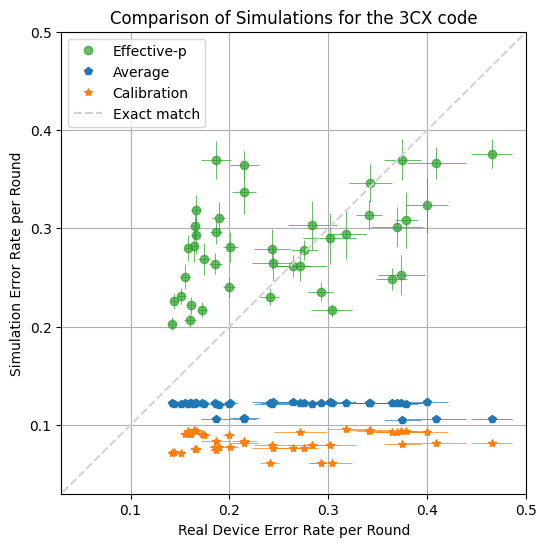

In [14]:
p_eff_points = [np.array(LF_exp_d).flatten(),np.array(LF_sim_d).flatten(),np.array(LF_exp_d_err).flatten(),np.array(LF_sim_d_err).flatten()]
avg_points = [np.array(LF_exp_d).flatten(),np.array(LF_sim_avg_d).flatten(),np.array(LF_exp_d_err).flatten(),np.array(LF_sim_avg_d_err).flatten()]
calib_points = [np.array(LF_exp_d).flatten(),np.array(LF_sim_calib_d).flatten(),np.array(LF_exp_d_err).flatten(),np.array(LF_sim_calib_d_err).flatten()]

offsets = [-4+4j,-4+8j,0+4j,0+8j,2+6j,-2+6j,-2+6j]
d_list = [3,3,3,3,3,3,4]
dds = ['XX','XXXX','XZX']

plt.figure(figsize=(6,6))
data_sets = [p_eff_points, avg_points, calib_points]
shapes = ['o', 'p', '*']
alphas = [.7, 1, 1]
labels = ['Effective-p', 'Average', 'Calibration']
for c in range(3):
    real_data, sim_data, real_error, sim_error = data_sets[c]
    real_data2 = []
    sim_data2 = []
    real_error2 = []
    sim_error2 = []
    param_list2 = []
    for d,offset in zip(d_list,offsets):
        for dd in dds:
            for logical_observable in ['X','Z']:
                real_data_of_T = []
                sim_data_of_T = []
                real_error_of_T = []
                sim_error_of_T = []
                T_list = []
                for ind, param in enumerate(np.array(param_d).flatten()):
                    if param['d']==d and param['offset']==offset and param['dd']==dd and param['log_obs']==logical_observable:
                        real_data_of_T.append(real_data[ind])
                        sim_data_of_T.append(sim_data[ind])
                        real_error_of_T.append(real_error[ind])
                        sim_error_of_T.append(sim_error[ind])
                        T_list.append(param['T'])
                        if param['T']==2:
                            param_list2.append({'d': d,
                                            'log_obs': logical_observable,
                                            'offset': offset,
                                            'dd': dd})
                LE_per_round = fit_LE_per_round(T_list,real_data_of_T,input_per_round=True)
                real_data2.append(LE_per_round)
                LE_per_round2 = fit_LE_per_round(T_list,sim_data_of_T,input_per_round=True)
                sim_data2.append(LE_per_round2)
                real_error2.append(np.mean(real_error_of_T))
                sim_error2.append(np.mean(sim_error_of_T))
    
    print(f"{labels[c]}", np.corrcoef(real_data2,sim_data2)[0,1])
    plt.plot(real_data2, sim_data2, shapes[c], color=f'C{(c+2)%3}', label=f"{labels[c]}", alpha=alphas[c])
    plt.errorbar(real_data2, sim_data2, xerr = real_error2, yerr = sim_error2, linestyle=' ', color=f'C{(c+2)%3}', linewidth=.5)

plt.plot(np.linspace(0, .5, 100), np.linspace(0, .5, 100), '--', color='lightgrey', label='Exact match')
plt.ylabel('Simulation Error Rate per Round')
plt.xlabel('Real Device Error Rate per Round')
plt.title(f'Comparison of Simulations for the 3CX code')
plt.xlim(.03, .5)
plt.ylim(.03, .5)
plt.grid(which='both')
plt.legend()
# plt.savefig(home+"/paper_images/simulation_comparison_3CX.pdf")
plt.show()

In [15]:
def LF_of_T(param_list, LF_list, fix_params):
    Ts = []
    LFs = []
    for ind, param in enumerate(param_list):
        if param['d']==fix_params['d'] and param['log_obs']==fix_params['log_obs'] and param['offset']==fix_params['offset'] and param['dd']==fix_params['dd']:
            Ts.append(param['T'])
            LFs.append(LF_list[ind])
    return Ts,LFs

offsets = [-4+4j,-4+8j,0+4j,0+8j,2+6j,-2+6j,-2+6j]
d_list = [3,3,3,3,3,3,4]
dds = ['XX','XXXX','XZX']

peff_list = []
data_effp_dev = []
param_fix_list = []
for d,offset in zip(d_list,offsets):
    for dd in dds:
        for logical_observable in ['X','Z']:
            LFs_Trounds = []
            for LF_list, LF_err_list in [[LF_sim_d,LF_sim_d_err],[LF_exp_d,LF_exp_d_err]]:
                Ts, LFs = LF_of_T(param_list=np.array(param_d).flatten(),LF_list=list(zip(np.array(LF_list).flatten(),np.array(DL_d).flatten())),
                                fix_params={'d': d,
                                            'log_obs': logical_observable,
                                            'offset': offset,
                                            'dd': dd}
                                            )
                LFs, DLs = np.transpose(LFs)
                LFs_Trounds.append([discount_LogFail(LF,1,T) for LF,T in zip(LFs,Ts)])
            peff_list.append(DLfit_inv(np.mean(DLs),22.3))
            LFs_Trounds = np.array(LFs_Trounds)
            param_fix_list.append({'d': d,'log_obs': logical_observable,'offset': offset,'dd': dd})
            data_effp_dev.append(np.mean(abs(LFs_Trounds[0]-LFs_Trounds[1])/(LFs_Trounds[0]+LFs_Trounds[1])))

min_peff_ind = np.argmin(peff_list)
min_peff_params = param_fix_list[min_peff_ind]
min_dev_ind = np.argmin(data_effp_dev)
min_dev_params = param_fix_list[min_dev_ind]
max_dev_ind = np.argmax(data_effp_dev)
max_dev_params = param_fix_list[max_dev_ind]
print('min p_eff:',min_peff_params)
print('min dev:',min_dev_params)
print('max dev:',max_dev_params)

min p_eff: {'d': 3, 'log_obs': 'Z', 'offset': (-4+8j), 'dd': 'XX'}
min dev: {'d': 4, 'log_obs': 'X', 'offset': (-2+6j), 'dd': 'XZX'}
max dev: {'d': 3, 'log_obs': 'Z', 'offset': 4j, 'dd': 'XZX'}


{'d': 3, 'log_obs': 'Z', 'offset': 4j, 'dd': 'XZX'}
  avg 0.12188111315278304
  calib 0.07587448157005469
  eff-p 0.31893501529559676
  data 0.16585572899823786
{'d': 4, 'log_obs': 'X', 'offset': (-2+6j), 'dd': 'XZX'}
  avg 0.10545616983036998
  calib 0.08107690573350677
  eff-p 0.3699009621496987
  data 0.3748436830140157
{'d': 3, 'log_obs': 'Z', 'offset': (-4+8j), 'dd': 'XX'}
  avg 0.1222584874421779
  calib 0.07166164642685699
  eff-p 0.20308488875531625
  data 0.14175479336486138


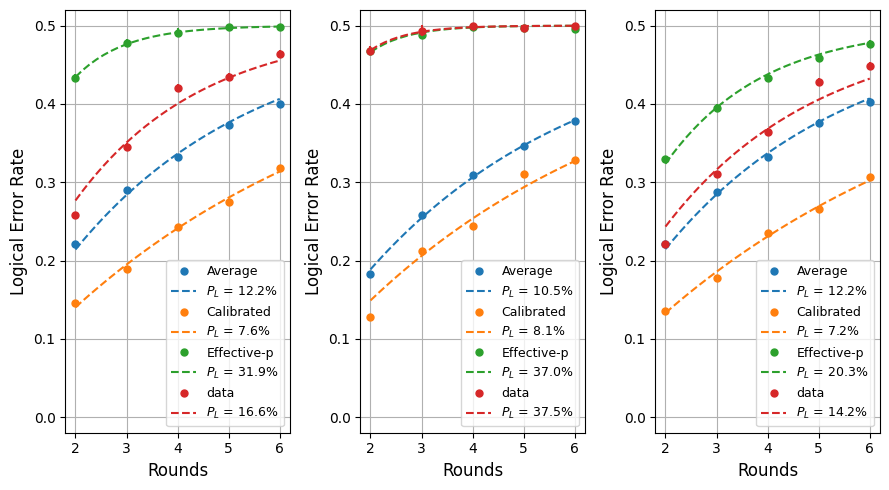

In [21]:
titles = ['Largest Difference ','Smallest Difference ',r'Lowest $\langle D\rangle$ ']
labels = ['Average', 'Calibrated','Effective-p','data']
shapes = ['o']*4#['x', 'p','*','h']
basis_dict = {"Z":r"$|0\rangle_L$","X":r"$|+\rangle_L$"}

plt.figure(figsize=(3.*3, 5))
min_T = 2 #min T run to calculate log fail rate from
for i, fix_params, title in zip(range(1,4),[max_dev_params,min_dev_params,min_peff_params],titles):
    plt.subplot(130+i)
    c=0
    print(fix_params)
    for LF_list, LF_err_list in [[LF_sim_avg_d,LF_sim_avg_d_err],[LF_sim_calib_d,LF_sim_calib_d_err],[LF_sim_d,LF_sim_d_err],[LF_exp_d,LF_exp_d_err]]:
        Ts, LFs = LF_of_T(param_list=np.array(param_d).flatten(),LF_list=list(zip(np.array(LF_list).flatten(),np.array(LF_err_list).flatten(),np.array(DL_d).flatten())),
                        fix_params=fix_params)
        LFs, LF_errs, DLs = np.transpose(LFs)
        peff = DLfit_inv(np.mean(DLs),22.3)
        LFs_Trounds = [discount_LogFail(LF,1,T) for LF,T in zip(LFs,Ts)]
        LF_errs_Trounds = [discount_LogFail_err(LF,LF_err,1,T) for LF,LF_err,T in zip(LFs,LF_errs,Ts)]
        plt.plot(Ts,LFs_Trounds, marker = shapes[c], markersize = 5,linestyle = '', label=labels[c],color=f'C{c}')
        plt.errorbar(Ts,LFs_Trounds,yerr=LF_errs_Trounds, linestyle = '', color=f'C{c}')
    
        #plot fitted function
        T_list = np.array(range(min_T,7))
        LE_per_round = fit_LE_per_round(T_list,LFs_Trounds,input_per_round=False)
        plt.plot(np.linspace(2,6,30),(1-(1-2*LE_per_round)**np.linspace(2,6,30))/2,'--', color=f'C{c}', label='$P_L$ = ' +str(round(100*LE_per_round,1))+'%')

        print(' ',['avg','calib','eff-p','data'][c],LE_per_round)
        c+=1

    plt.grid()
    plt.xticks(Ts)
    plt.xlabel('Rounds', fontsize = 12)
    plt.ylabel('Logical Error Rate', fontsize = 12)
    # plt.title(title+ r'($p_{eff}$='+f'{round(peff, 3)})\n$d={fix_params['d']}$, log = {basis_dict[fix_params['log_obs']]}, dd={fix_params['dd']}')
    # plt.hlines(.5, min(Ts), max(Ts), linestyles='dashed', color='gray'
    #         #    , label='pure noise'
    #            )
    plt.ylim(-0.02,0.52)
    plt.tight_layout()
    plt.legend(loc='lower right', fontsize = 9)
# plt.savefig(home+"/paper_images/simulation_comparison_3CX_examples.pdf", bbox_inches='tight')
plt.show()